![image](images/negative_words.png)

<center><b><font size="6">NLP Analysis of Boulder employers reviews</font></b></center>

<span style="color:red; font-size:1.5em">**Phase 4 Final Project**</span><br>
* Student name: <b>Elena Kazakova</b>
* Student pace: <b>full time</b>
* Cohort: <b>DS02222021</b>
* Scheduled project review date: <span style="color:red"><b>06/24/2021</b></span>
* Instructor name: <b>James Irving</b>
* Blog post URL: <span style="color:red"><b>TBD</b></span>

# Table of Contents 

*Click to jump to matching Markdown Header.*<br>

- **[Introduction](#INTRODUCTION)<br>**
- **[Obtain](#Obtain)**<br>
- **[Scrub](#Scrub)**<br>
- **[Explore](#Explore)**<br>
- **[Model](#Model)**<br>
- **[iNterpret](#iNterpret)**<br>
- **[Conclusions/Recommendations](#Conclusions-and-Recommendation)<br>**
___

# Introduction

## Business Problem

# Obtain

## Importing packages and modules

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import string
import re
import seaborn as sns
import inspect
import pickle
import itertools
import joblib

from sklearn import metrics
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, RegexpTokenizer, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.collocations import *
from nltk import pos_tag
#from keras.preprocessing.text import Tokenizer, text_to_word_sequence
import matplotlib_venn as venn
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
from wordcloud import WordCloud, STOPWORDS
from sklearn.pipeline import Pipeline, make_pipeline

from xgboost import XGBRFClassifier,XGBClassifier
from sklearn.dummy import DummyClassifier
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


#from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve


from warnings import filterwarnings
filterwarnings('ignore')

np.random.seed(0)
set_config(display='diagram')

## Functions used

In [2]:

def simple_model_validation(model, set_list, title1, title2):
    """A function generating confusion matrices (train/test) with model metrics
    Test set can be either a validation set or a final test set
    *******************
    Arguments:
    model: a model to evaluate
    set_list: a list of datasets names [X_train, X_test, y_train, y_test]
    titel1: a title for the training set confusion matrix
    title2: a title for the test set confusion matrix"""
    
    X_train=set_list[0]
    X_test=set_list[1]
    y_train=set_list[2]
    y_test=set_list[3]
    
    y_pred1 = model.predict(X_train)
    y_pred2 = model.predict(X_test)
    
    print('***************************************')
    print(model)
    print('***************************************\n')
    
    
    print('Classification Report for training set')
    print('***************************************')
    print(metrics.classification_report(y_train, y_pred1)+'\n')
    print('Classification Report for validation/test set')
    print('***************************************')
    print(metrics.classification_report(y_test, y_pred2)+'\n')
    
    print('***************************************')
    
    categories=['Negative','Neutral','Positive']
    cm1=confusion_matrix(y_train, model.predict(X_train), normalize='true')
    cm2=confusion_matrix(y_test, model.predict(X_test), normalize='true')
    
    fig = plt.figure(figsize=(7,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.set_title(title1)
    ax2.set_title(title2)

    sns.heatmap(cm1, annot=cm1.round(3), fmt="", cmap='Reds', cbar=True,
                xticklabels=categories, yticklabels=categories, ax=ax1)
    sns.heatmap(cm2, annot=cm2.round(3), fmt="", cmap='Reds', cbar=True,
                 xticklabels=categories, yticklabels=categories, ax=ax2)
    plt.tight_layout()
    plt.show()

    return
    
def manual_cleanup(corpus_body_element, dict_replace, sw=stopwords.words('english'),
                   punct_custom=string.punctuation.replace('$',''), print_=True, plot_=True, n=30):
    
    """
    This function itakes in a corpus body element and clean it up in the most simple way:
    1. split it into a list of words
    2. make list elements lower case
    3. remove punctuation (standard minus '$')
    4. remove stopwords
    5. remove numbers
    6. remove empty list elements
    
    It also plots the FreqDist plot of the final list if plot_=True and
    prints original and final word counts if print_=True
    
    ***********************
    Args:
    corpus_body_element: a text element in corpus (review)
    dict_replace: dictionary with new and old values in corpus_body_element to be replaced (like HR or OT)
    sw: stopwords to be used
    punct_custom: customized default string.puctuation characters
    print_: printing flag, default=True
    plot_:  ploting flag, default=True
    n: number of tokens to plot, default=30"""
    
    
    for old, new in dict_replace.items():
        corpus_body_element = corpus_body_element.replace(old, new)

    tokens=corpus_body_element.split(' ')
    corpus_body_element_cleaned = [word.lower() for word in tokens]
    corpus_body_element_cleaned = [s.translate(str.maketrans('', '', punct_custom))\
                  for s in corpus_body_element_cleaned]
    corpus_body_element_cleaned = [token for token in corpus_body_element_cleaned if\
                  token not in sw]
    corpus_body_element_cleaned = [s.translate(str.maketrans('', '', '0123456789')) \
                  for s in corpus_body_element_cleaned]
    corpus_body_element_cleaned = [s for s in corpus_body_element_cleaned if s != '']
    
    if print_:
        print(f"The original token list has {len(set(tokens))} words")
        print(f"After the full manual cleanup, the review word list has {len(set(corpus_body_element_cleaned))} unique words")
        
    if plot_:
        fdist = FreqDist(corpus_body_element_cleaned)
        plt.figure(figsize=(7, 7))
        fdist.plot(n);
    
    return corpus_body_element_cleaned

def changing_target(original_df, column, a=1, b=2, c=3, d=4, e=5, f=0):
    """Streamlining the target classes adjustments"""
    df=original_df.copy()
    df.loc[((df[column] == a) | (df[column] == b)) , column] = '1'
    df.loc[((df[column] == d) | (df[column] == e)) , column] = '3'
    df.loc[((df[column] == c) | (df[column] == f)) , column] = '2'
    return df

def review_tokenize_only(review, tokenizer, dict_replace, stop_words, print_=True, plot_=True, n=30):
    """
    Function tokenizes with RegexpTokenizer,tags with simplified pos-tags plus lemmatizes based on tags.
    ***************
    Args:
    
    review: string to process
    tokenizer: tokenizer to be used
    stop_words: stopwords list, standard or customized
    print_: flag to print the number of unique words after the processing or not, default is True;
    plot_: flag to plot the number of unique words after the processing or not, default is True;
            should be set to False for bulk processing.
    n: a number of words to plot
    """
    for old, new in dict_replace.items():
        review = review.replace(old, new)
        
    re_tokens = tokenizer.tokenize(review)
    re_tokens = [token.lower() for token in re_tokens]
    re_tokens = [token for token in re_tokens if token not in stop_words]
    
    if print_:
        print(f"After using\n\n {tokenizer}\n\n our sample review has {len(set(re_tokens))} unique words")
        
    if plot_:
        fdist = FreqDist(re_tokens)
        plt.figure(figsize=(7, 7))
        fdist.plot(n);
    return re_tokens

def review_tokenize_lemmatize(review, tokenizer, lemmatizer, dict_replace, stop_words, print_=True, plot_=True, n=30):
    """
    Function tokenizes with RegexpTokenizer,tags with simplified pos-tags plus lemmatizes based on tags.
    ***************
    Args:
    
    review: string to process
    tokenizer: tokenizer to be used
    lemmatizer: lemmatizer to be used
    stop_words: stopwords list, standard or customized
    print_: flag to print the number of unique words after the processing or not, default is True;
    plot_: flag to plot the number of unique words after the processing or not, default is True;
            should be set to False for bulk processing.
    n: a number of words to plot
    """
    re_tokens=review_tokenize_only(review, tokenizer, dict_replace, stop_words, print_=False, plot_=False)
    review_tokens_tagged = pos_tag(re_tokens)
    review_tokens_tagged = [(word[0], get_wordnet_pos(word[1])) for word in review_tokens_tagged]
    review_tokens_tagged = [lemmatizer.lemmatize(word[0], word[1]) for word in review_tokens_tagged]

    if print_:
        print(f"After using\n\n {tokenizer}\n&\n{lemmatizer}\n\n our sample review has {len(set(review_tokens_tagged))} unique lemmas")
        
    if plot_:
        fdist = FreqDist(review_tokens_tagged)
        plt.figure(figsize=(7, 7))
        fdist.plot(n);
    return review_tokens_tagged

def get_wordnet_pos(treebank_tag):
    """
    Translate nltk POS to wordnet tags to feed into a lemmatizer. 
    This function is very similar to the one used in the CL lecture. 
    And it is the same function as in stackoverflow
    
    Args
    ***********************
    treebank_tag: a tag from pos_tag processing of a list of words
    
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def adding_to_models_dict(dict_, descr, classifier_name, set_list, model, pickle_file):
    """A function to build a dictionary with all built and evaluated models metrics and information for easy comparison.
    ***************
    Arguments
    dict_: dictionary name
    descr: description of the model ('str')
    classifier_name: the name of the classifier ('str')
    set_list: a list of dataframe names [X_train, X_test, y_train, y_test]
    model: model to add (classifier)
    joblib_file: the name of the file with the saved model ('str')
    """
    X_train=set_list[0]
    X_test=set_list[1]
    y_train=set_list[2]
    y_test=set_list[3]
    
    y_pred1 = model.predict(X_train)
    y_pred2 = model.predict(X_test)
    
    acc_score_train=round(metrics.accuracy_score(y_pred1, y_train),3)
    acc_score_test=round(metrics.accuracy_score(y_pred2, y_test),3)
    
    f1_score_train=round(metrics.f1_score(y_pred1, y_train, average="macro"),3)
    f1_score_test=round(metrics.f1_score(y_pred2, y_test, average="macro"),3)
    
    dict_['Classifier Name'].append(classifier_name)
    dict_['Description'].append(descr)
    dict_['Training or Val/Test'].append('training')
    dict_['Accuracy'].append(acc_score_train)
    dict_['F1 Score'].append(f1_score_train)
    dict_['Saved model'].append(pickle_file)
    
    dict_['Classifier Name'].append(classifier_name)
    dict_['Description'].append(descr)
    dict_['Training or Val/Test'].append('val/test')
    dict_['Accuracy'].append(acc_score_train)
    dict_['F1 Score'].append(f1_score_test)
    dict_['Saved model'].append(pickle_file)
    
    return dict_


## Data Understanding

## Importing data

### Importing original scrapped data

In [3]:
# All csv files from multiple scraps

df1=pd.read_csv('data/scrap_results1.csv')
df2=pd.read_csv('data/scrap_results2.csv')
df3=pd.read_csv('data/scrap_results3.csv')
df4=pd.read_csv('data/scrap_results4.csv')
df5=pd.read_csv('data/scrap_results5.csv')
df6=pd.read_csv('data/scrap_results6.csv')
df7=pd.read_csv('data/scrap_results7.csv')
df8=pd.read_csv('data/scrap_results8.csv')
df9=pd.read_csv('data/scrap_results9.csv')
df10=pd.read_csv('data/scrap_results10.csv')
df=pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10], ignore_index=True)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [4]:
df.head()

,Company,ReviewID,Rating,Review_Text
0,Ball Aerospace,1f4e4k5dk2v72000,4.0,I worked as a contractor for them for about tw...
1,Ball Aerospace,1f76ir3183obs000,1.0,"Worst place I've ever worked, hands down."
2,Ball Aerospace,1f5rn12k9u3af800,3.0,The compnay has good benefits and even a small...
3,Ball Aerospace,1f5e5q2f1u2n1800,1.0,Company has no life and work balance. Everyda...
4,Ball Aerospace,1f3b4lrdou3bc800,5.0,"I no long work for Ball, the drive to work was..."


In [5]:
df.Rating.value_counts()

5.0    37147
4.0    33875
3.0    26850
1.0    12285
2.0    11463
Name: Rating, dtype: int64

In [6]:
df=changing_target(df, 'Rating')

In [7]:
df.head()

,Company,ReviewID,Rating,Review_Text
0,Ball Aerospace,1f4e4k5dk2v72000,3,I worked as a contractor for them for about tw...
1,Ball Aerospace,1f76ir3183obs000,1,"Worst place I've ever worked, hands down."
2,Ball Aerospace,1f5rn12k9u3af800,2,The compnay has good benefits and even a small...
3,Ball Aerospace,1f5e5q2f1u2n1800,1,Company has no life and work balance. Everyda...
4,Ball Aerospace,1f3b4lrdou3bc800,3,"I no long work for Ball, the drive to work was..."


## Keeping all frequently variables together

#### Eliminating company names from the word pool

In [8]:
list_companies=list(df['Company'].unique())
list_companies

['Ball Aerospace',
 'University of Colorado Boulder',
 'Boulder Valley School District',
 'Boulder Community Health',
 'Boulder County, CO',
 'Splunk',
 'Naropa University',
 'Amazon.com',
 'Brookdale Senior Living',
 'IBM',
 'NETA',
 'Apple',
 'City of Boulder, CO',
 'Medtronic',
 'Emerson',
 'NetApp',
 'Zayo Group',
 'Whole Foods Market',
 'Particle Measuring Systems',
 'Boulder Medical Center',
 'Sage Hospitality',
 'University of Colorado',
 'Mental Health Partners',
 'Agilent Technologies',
 'Frasier Meadows',
 'Cozymeal',
 'IHS Markit',
 'National Renewable Energy Laboratory',
 'University Corporation for Atmospheric Research',
 'Sprouts Farmers Market',
 'KPMG',
 'New Relic',
 'Excelitas Technologies',
 'Northrop Grumman',
 'KBI Biopharma',
 'Ricoh',
 'Embassy Suites by Hilton',
 'U.S. Department of Commerce',
 'InVitae',
 'Pfizer',
 'SUEZ',
 'PetSmart',
 'Craft Health',
 'Imagine!',
 'King Soopers',
 'Safeway']

In [9]:
dict_replace2={' Center':'',' Technologies':'',' of Colorado':'',' Commerce':'','Medical':'','Particle':'',
              'Community':'',' Health':'','Suites':'',' Market':'',' Systems':'','Senior':'','Living':'',
              'Department':'','School ':'','Research':'','New':'','Group':'',' Measuring':'',' District':'',
              ' Energy':'','University ':'','Hospitality':'','National ':'','Mental':'',' Partners':''}

list_companies_tokens=[]
for element in list_companies:
    token=manual_cleanup(element, dict_replace2, print_=False, plot_=False, n=30)
    list_companies_tokens.append(token)
    
#list_companies_tokens

flat_list_companies_tokens = [item for sublist in list_companies_tokens for item in sublist]
flat_list_companies_tokens=list(set(flat_list_companies_tokens))
companies_sw=flat_list_companies_tokens

#### Variables

In [10]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
sw=stopwords.words('english')
sw2=stopwords.words('english')+companies_sw+['work']
dict_replace={' OT ': ' overtime ', ' HR ':' human resources ' }
punct_custom=string.punctuation.replace('$','')

## Description of the variables

# Scrub and Explore

## Exploratory Data Analysis

### Distribution of Reviews

<AxesSubplot:>

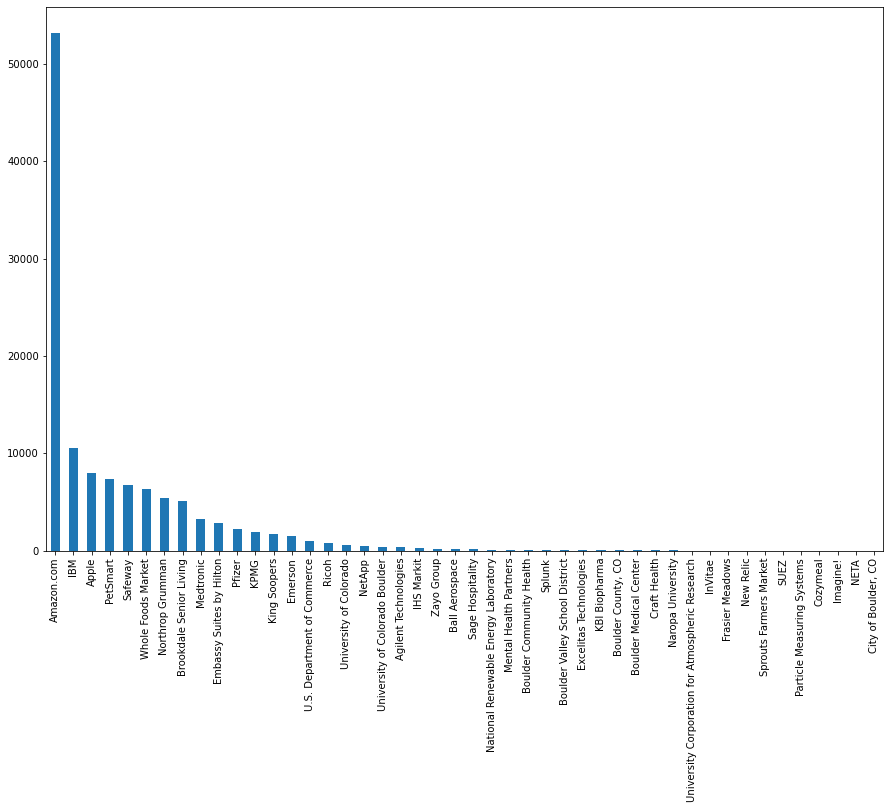

In [11]:
df['Company'].value_counts().plot(kind='bar', figsize=(15,10))

In [12]:
df_other=df.loc[df['Company']!='Amazon.com']
df_other.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68435 entries, 0 to 176255
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Company      68435 non-null  object
 1   ReviewID     68435 non-null  object
 2   Rating       68435 non-null  object
 3   Review_Text  68435 non-null  object
dtypes: object(4)
memory usage: 2.6+ MB


In [13]:
df_amazon=df.loc[df['Company']=='Amazon.com']
df_amazon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53185 entries, 810 to 102496
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Company      53185 non-null  object
 1   ReviewID     53185 non-null  object
 2   Rating       53185 non-null  object
 3   Review_Text  53185 non-null  object
dtypes: object(4)
memory usage: 2.0+ MB


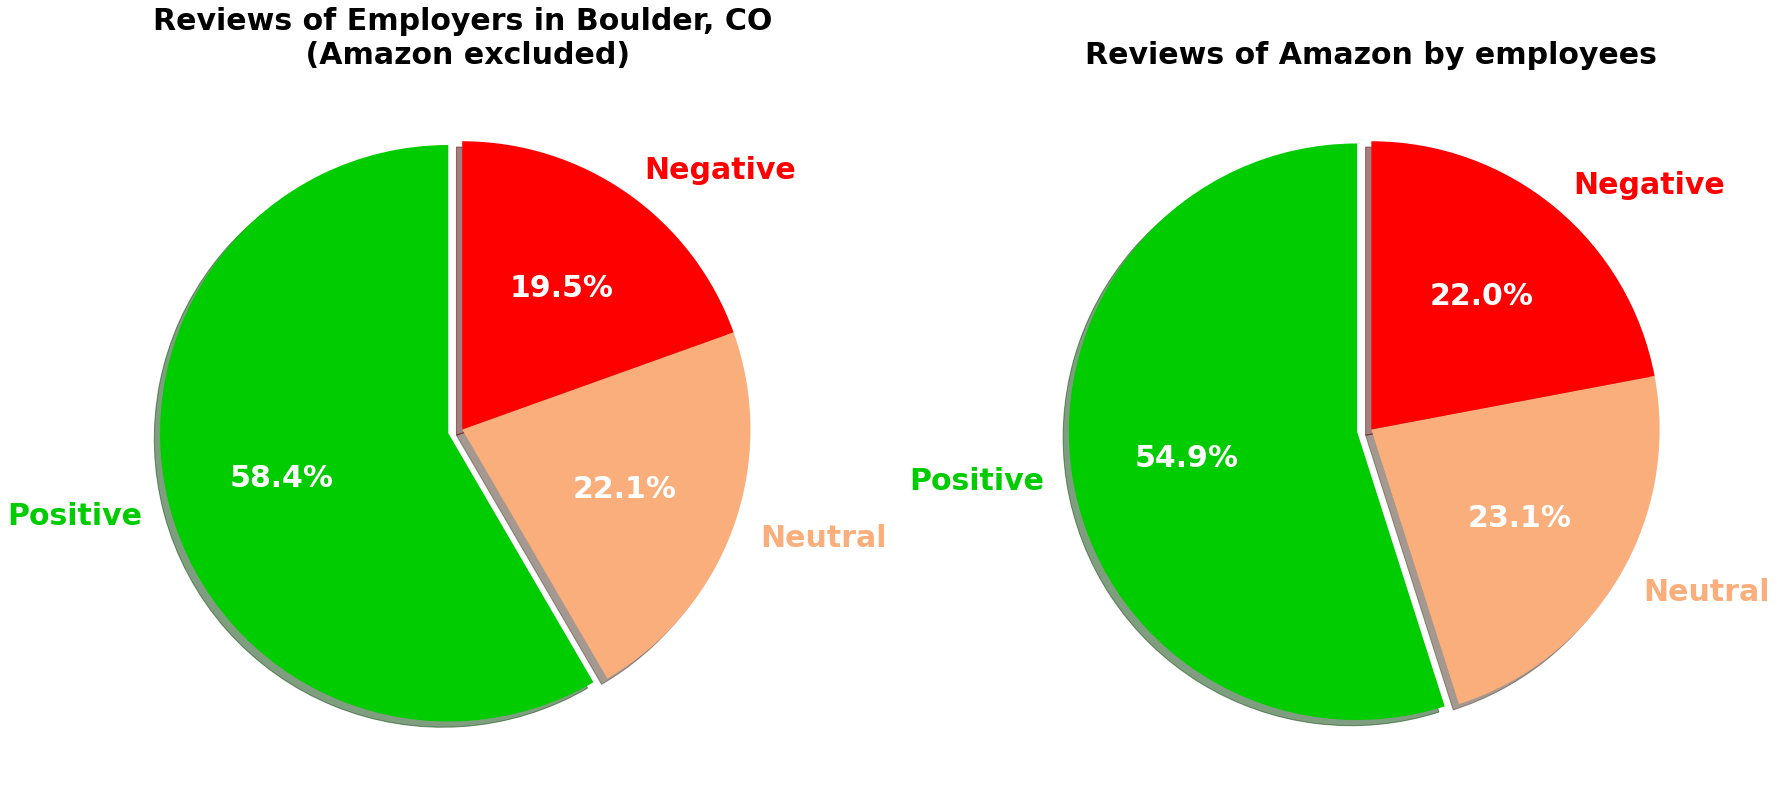

In [14]:
# Pie plot of Rating values for the full dataset and Amazon dataset separately
labels = ['Positive', 'Neutral','Negative']
colors = ['#00cc00','#FAAE7B', '#ff0000']
explode = [0.05, 0, 0]

fig, axes = plt.subplots(figsize=(25,45), ncols=2)

patches1, texts1, pcts1 = axes[0].pie(df.Rating.value_counts(), labels = labels, explode = explode, colors=colors, shadow = True,
        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 30,'color':'white','weight':'bold'})
for i, patch in enumerate(patches1):
    texts1[i].set_color(patch.get_facecolor())    
plt.setp(pcts1, color='white')
plt.setp(texts1, fontweight=800)
axes[0].set_title('Reviews of Employers in Boulder, CO\n (Amazon excluded)', fontsize=30, weight='bold');



patches2, texts2, pcts2 = axes[1].pie(df_amazon.Rating.value_counts(), labels = labels, explode = explode, colors=colors, shadow = True,
        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 30,'color':'white','weight':'bold'})
for i, patch in enumerate(patches2):
    texts2[i].set_color(patch.get_facecolor())    
plt.setp(pcts2, color='white')
plt.setp(texts2, fontweight=800)


axes[1].set_title('Reviews of Amazon by employees', fontsize=30, weight='bold');

plt.tight_layout()

plt.show() 

In [15]:
# plt.figure(figsize = (15,8))
# ax=sns.countplot(x='Company', data=df, order=df.Company.value_counts().index)
df_other=df.loc[df['Company']!='Amazon.com']
df_bigboys=df_other.loc[df_other['Company'].isin(['IBM','Apple','PetSmart','Safeway',
                                                  'Whole Foods Market','Northrop Grumman','Brookdale Senior Living',
                                                 'Pfizer','KPMG','King Soopers','Medtronic', 'Emerson',
                                                  'Embassy Suites by Hilton','Ricoh','NetApp','Agilent Technologies',
                                                 'University of Colorado','University of Colorado Boulder',
                                                 'U.S. Department of Commerce'])]



df_littleboys=df_other.loc[~df_other['Company'].isin(['IBM','Apple','PetSmart','Safeway',
                                                  'Whole Foods Market','Northrop Grumman','Brookdale Senior Living',
                                                 'Pfizer','KPMG','King Soopers','Medtronic', 'Emerson',
                                                  'Embassy Suites by Hilton','Ricoh','NetApp','Agilent Technologies',
                                                 'University of Colorado','University of Colorado Boulder',
                                                 'U.S. Department of Commerce'])]

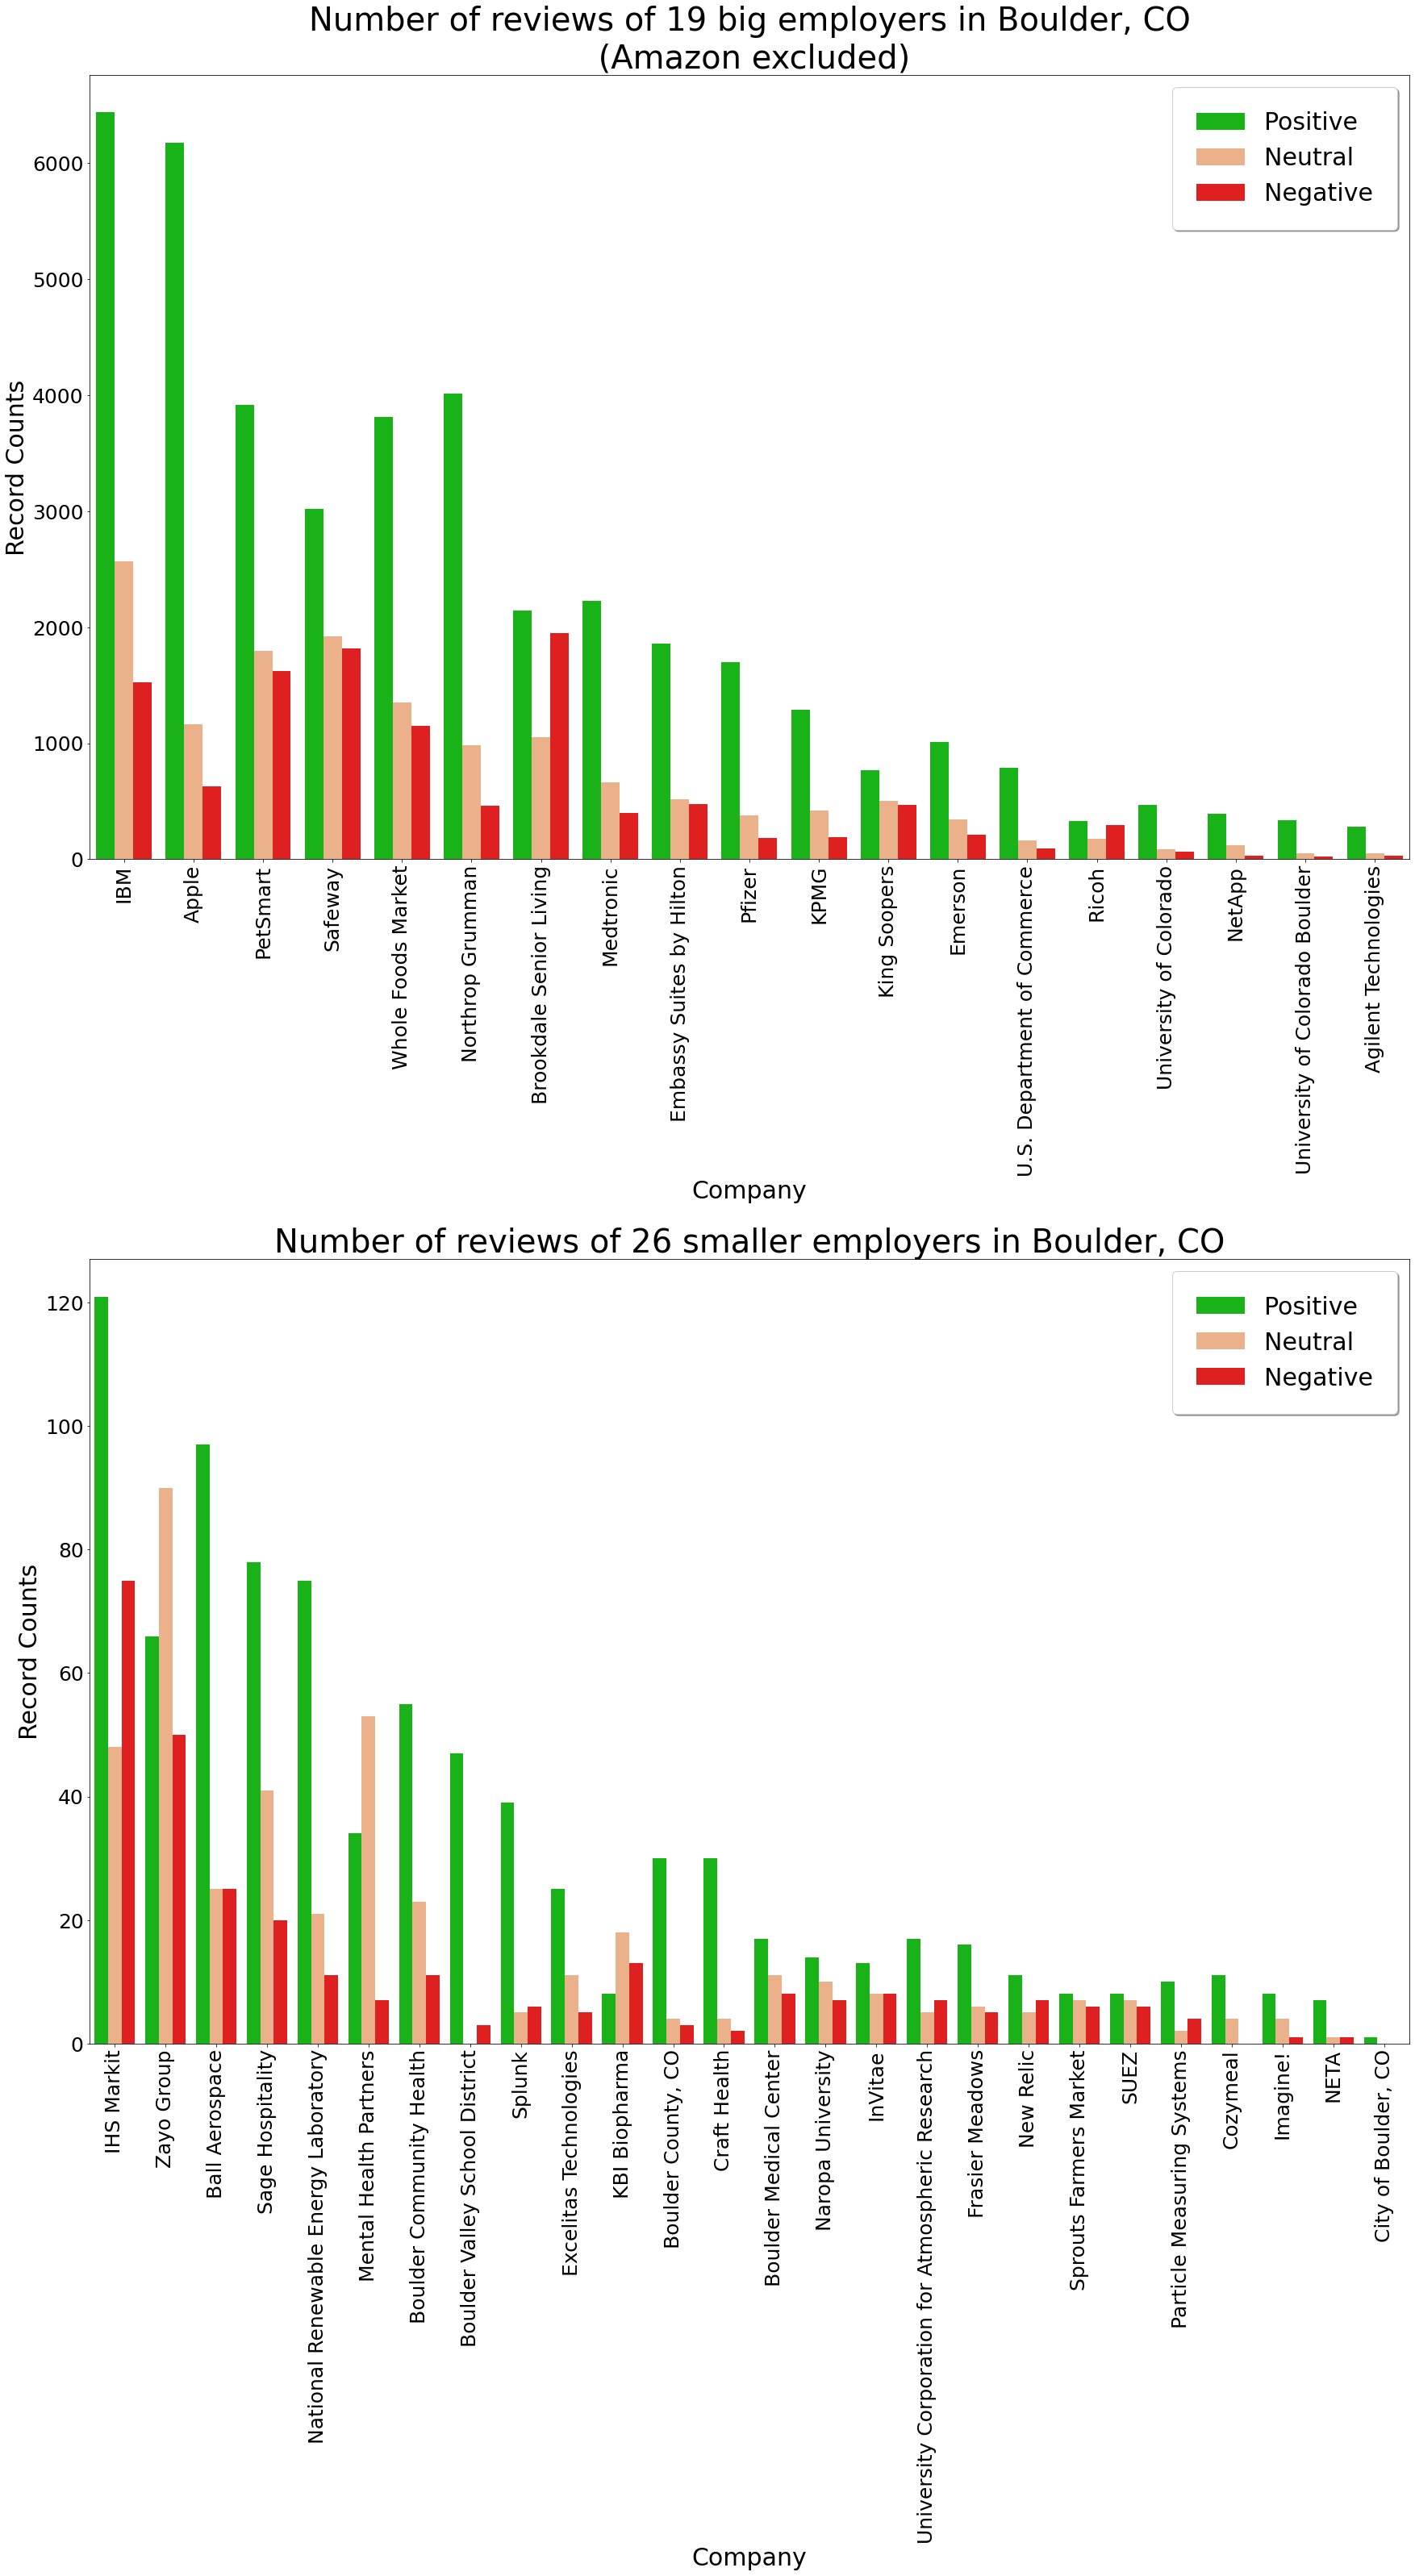

In [16]:
fig, axes = plt.subplots(figsize=(25,45), nrows=2)

sns.countplot(x='Company', data=df_bigboys, hue='Rating', palette=['#00cc00','#FAAE7B', '#ff0000'],
              order=df_bigboys.Company.value_counts().index, ax=axes[0])
sns.countplot(x='Company', data=df_littleboys, hue='Rating', palette=['#00cc00','#FAAE7B', '#ff0000'],
              order=df_littleboys.Company.value_counts().index, ax=axes[1])


axes[0].set_title('Number of reviews of 19 big employers in Boulder, CO\n (Amazon excluded)', fontsize=40);
axes[0].set_ylabel('Record Counts', fontsize=30);
axes[0].set_xlabel('Company', fontsize=30);
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, fontsize=25)
axes[0].tick_params(labelsize=25)
axes[0].legend(['Positive', 'Neutral','Negative'], fancybox=True, framealpha=1, shadow=True, borderpad=1, fontsize=30,
              loc='upper right')

axes[1].set_title('Number of reviews of 26 smaller employers in Boulder, CO', fontsize=40);
axes[1].set_ylabel('Record Counts', fontsize=30)
axes[1].set_xlabel('Company', fontsize=30);
axes[1].tick_params(labelsize=25)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, fontsize=25)
axes[1].legend(['Positive', 'Neutral','Negative'], fancybox=True, framealpha=1, shadow=True, borderpad=1, fontsize=30,
              loc='upper right')

plt.tight_layout(pad=3)
sns.set_context("talk");

### Exploring corpus (body and target)

In [17]:
corpus=df.drop(['Company','ReviewID'], axis=1).copy()
corpus=corpus.rename(columns={'Rating': 'target', 'Review_Text': 'body'})
corpus.reset_index(drop=True, inplace=True)
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121620 entries, 0 to 121619
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  121620 non-null  object
 1   body    121620 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [18]:
corpus.shape

(121620, 2)

In [19]:
corpus.head()

,target,body
0,3,I worked as a contractor for them for about tw...
1,1,"Worst place I've ever worked, hands down."
2,2,The compnay has good benefits and even a small...
3,1,Company has no life and work balance. Everyda...
4,3,"I no long work for Ball, the drive to work was..."


In [20]:
corpus.target.value_counts()

3    71022
2    26850
1    23748
Name: target, dtype: int64

In [21]:
print(len(corpus))

121620


### Venn diagrams

In [22]:
# Priliminary tokenization for EDA (custom tokenizer)

> It's a dataframe with tokenizes reviews in 'tokens' column. Filling it in took about 17.5 minutes, so I saved the result to 'eda_pickle.pkl' to use in the EDA process

In [23]:
# dict_replace={' OT ': ' overtime ', ' HR ':' human resources '}

# # review_sample = corpus.iloc[2043].body
# # corpus_body_element_cleaned_man=manual_cleanup(review_sample, dict_replace, print_=False, plot_=False)

# df_venn=corpus.copy()
# df_venn['tokens'] = ''

# for i in range(0,len(df_venn)):
#     df_venn.tokens[i]=manual_cleanup(df_venn.body[i], dict_replace, print_=False, plot_=False)

# df_venn.to_pickle('eda_pickle.pkl')

In [24]:
df_eda=pd.read_pickle('eda_pickle.pkl')
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121620 entries, 0 to 121619
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  121620 non-null  object
 1   body    121620 non-null  object
 2   tokens  121620 non-null  object
dtypes: object(3)
memory usage: 2.8+ MB


In [25]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121620 entries, 0 to 121619
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  121620 non-null  object
 1   body    121620 non-null  object
 2   tokens  121620 non-null  object
dtypes: object(3)
memory usage: 2.8+ MB


In [26]:
df_rating_negative=df_eda.loc[df_eda.target=='1']
df_rating_neutral=df_eda.loc[df_eda.target=='2']
df_rating_positive=df_eda.loc[df_eda.target=='3']
print(len(df_rating_negative), len(df_rating_neutral), len(df_rating_positive))

23748 26850 71022


In [27]:
df_rating_negative.head()

,target,body,tokens
1,1,"Worst place I've ever worked, hands down.","[worst, place, ive, ever, worked, hands]"
3,1,Company has no life and work balance. Everyda...,"[company, life, work, balance, everyday, full,..."
5,1,I’ve watched Ball morph into a management stra...,"[i’ve, watched, ball, morph, management, strat..."
7,1,The management at this company is clueless as ...,"[management, company, clueless, high, work, lo..."
8,1,Ball has an old reputation of being a great co...,"[ball, old, reputation, great, company, reputa..."


In [28]:
negative_words=list(df_rating_negative.tokens)
flat_list_negative_words = []
for sublist in negative_words:
    for item in sublist:
        flat_list_negative_words.append(item)
set_negative_words=set(flat_list_negative_words)
len(set_negative_words)

25887

In [29]:
positive_words=list(df_rating_positive.tokens)
flat_list_positive_words = []
for sublist in positive_words:
    for item in sublist:
        flat_list_positive_words.append(item)
set_positive_words=set(flat_list_positive_words)
len(set_positive_words)

38091

In [30]:
neutral_words=list(df_rating_neutral.tokens)
flat_list_neutral_words = []
for sublist in neutral_words:
    for item in sublist:
        flat_list_neutral_words.append(item)
set_neutral_words=set(flat_list_neutral_words)
len(set_neutral_words)

23070

In [31]:
#flat_list = [item for sublist in t for item in sublist]

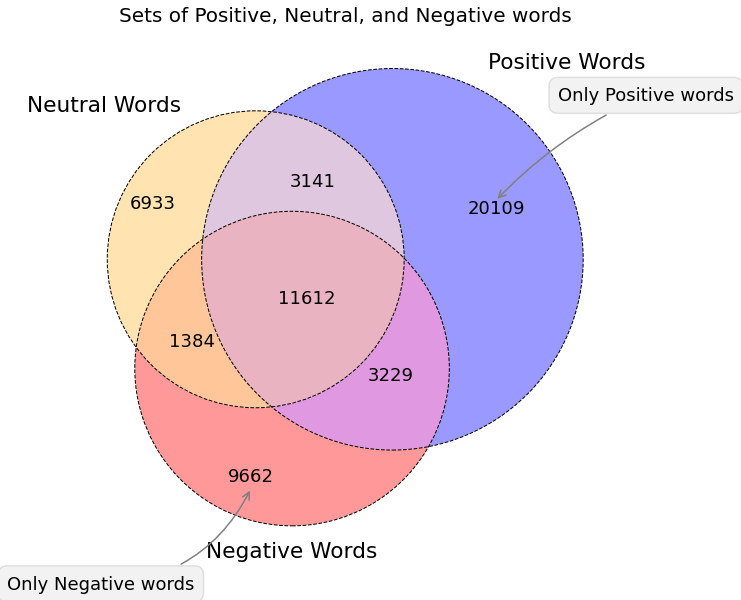

In [32]:

plt.figure(figsize=(10, 10))
ax=plt.gca()


sets=[set_neutral_words, set_positive_words, set_negative_words]
labels=('Neutral Words', 'Positive Words', 'Negative Words')

v=venn3(subsets=sets, set_labels = labels, ax=ax, set_colors=("orange", "blue", "red"))

v.get_patch_by_id('100').set_alpha(0.3)


venn3_circles(subsets=sets,
              linestyle="dashed", linewidth=1)

plt.annotate('Only Positive words',
             xy=v.get_label_by_id('010').get_position() - np.array([0, -0.02]), xytext=(150,100),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round, pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1',color='gray'))

plt.annotate('Only Negative words',
             xy=v.get_label_by_id('001').get_position() - np.array([0, 0.03]), xytext=(-150,-100),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round, pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3',color='gray'))


plt.title('Sets of Positive, Neutral, and Negative words', fontsize='20')
plt.show()

### Word Clouds

In [33]:
text_positive=' '.join(flat_list_positive_words)
text_negative=' '.join(flat_list_negative_words)
text_neutral=' '.join(flat_list_neutral_words)
stopwords_cloud=set(sw)
stopwords_cloud.update(['work', 'job', 'amazon', 'company','good','great','place','also','really',
                        'overall','would','get','lot', 'enjoyed','enjoy','love','however','make',
                        'loved','even','done','still','like','come','well','though','give', 'u',
                         'go','thing','really','one','take','want','make','could','say'])
cloud_kws=dict(stopwords=stopwords_cloud, width=1200, height=800, min_font_size=10, max_words=30,
               collocation_threshold = 5)

# Create a dictionary to generate all three clouds
wordcloud_dict={}
wordcloud_dict['Negative']= WordCloud(**cloud_kws,colormap='Reds').generate(text_negative)
wordcloud_dict['Positive']= WordCloud(**cloud_kws,colormap='Greens').generate(text_positive)
wordcloud_dict['Neutral']= WordCloud(**cloud_kws,colormap='Greys').generate(text_neutral)
wordcloud_dict

{'Negative': <wordcloud.wordcloud.WordCloud at 0x1e9d05ff400>,
 'Positive': <wordcloud.wordcloud.WordCloud at 0x1e9d05d2b20>,
 'Neutral': <wordcloud.wordcloud.WordCloud at 0x1e9cca7fb80>}

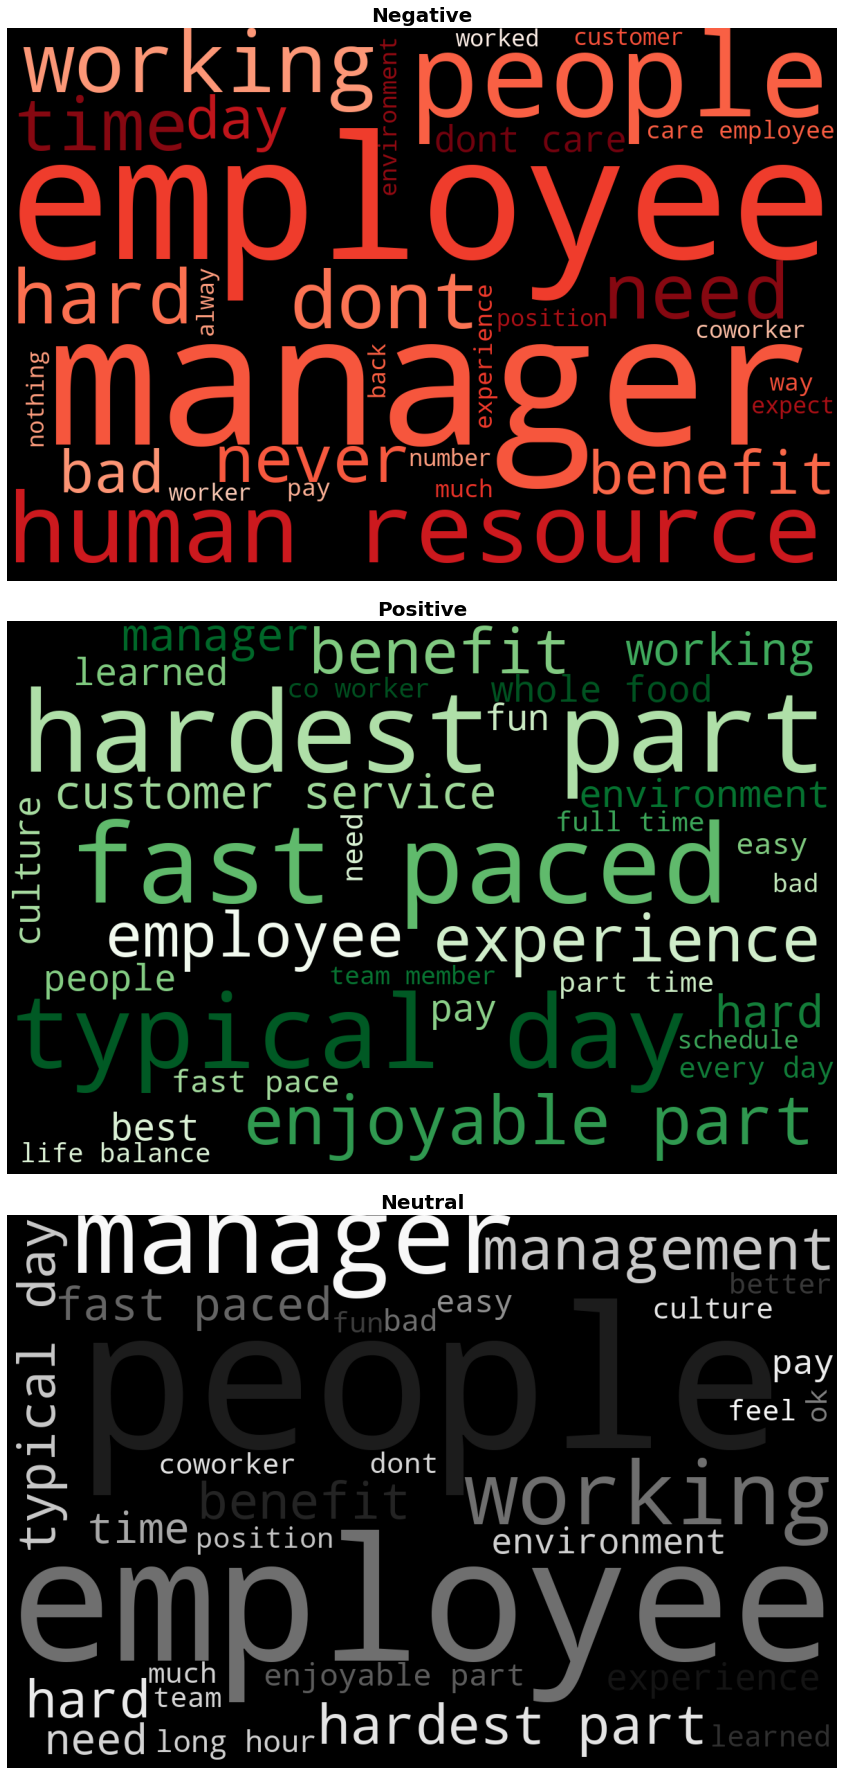

In [34]:
# wordcloud = WordCloud(stopwords=stopwords_cloud_p,max_font_size=100, max_words=30, 
#                       collocation_threshold = 5,background_color="white").generate(text_negative)

# Display the generated images:

fig, ax=plt.subplots(nrows=3, figsize=(15,25))
title_font={'fontweight':'bold','fontsize':20}

i=0
for rating, cloud in wordcloud_dict.items():
    ax[i].imshow(cloud)
    ax[i].set_title(rating, fontdict=title_font)
    ax[i].axis('off')
    i+=1

plt.tight_layout()
plt.show()

In [35]:
# Exploring results of the wordclouds

df_negative=df_eda.loc[df_eda.target=='1']
df_neutral=df_eda.loc[df_eda.target=='2']
df_positive=df_eda.loc[df_eda.target=='3']
df_negative=df_negative.reset_index(drop=True)
df_neutral=df_neutral.reset_index(drop=True)
df_positive=df_positive.reset_index(drop=True)

df_temp=df_positive[df_positive['body'].str.contains('hardest part')]
df_temp=df_temp.reset_index(drop=True)

In [36]:
df_temp.body[10]

'I work at a day treatment school with BVSD, my typical day at work is always changing depending on the students. I learned how to handle different students with different mental capabilities. The hardest part of my job is sometimes having to put hands-on on another student, whether it is to protect them from other or themselves. The most enjoyable part of the job is having our students transition to a mainstream school. The management I work closely with is amazing. They always have time to check in with me and they give great constructive criticism.'

>**It's a placeholder for my conclusions based on the wordclouds**

### Word distributions

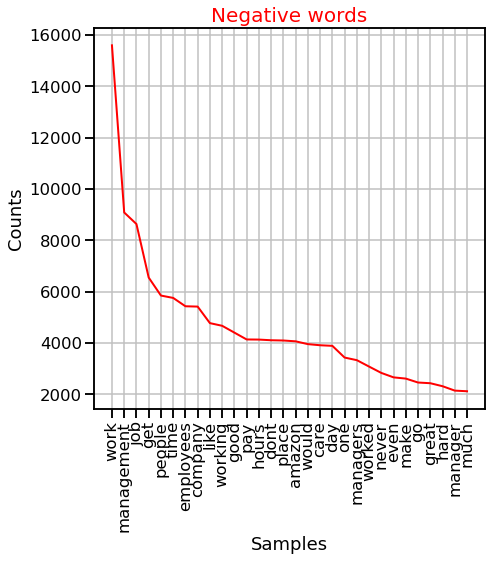

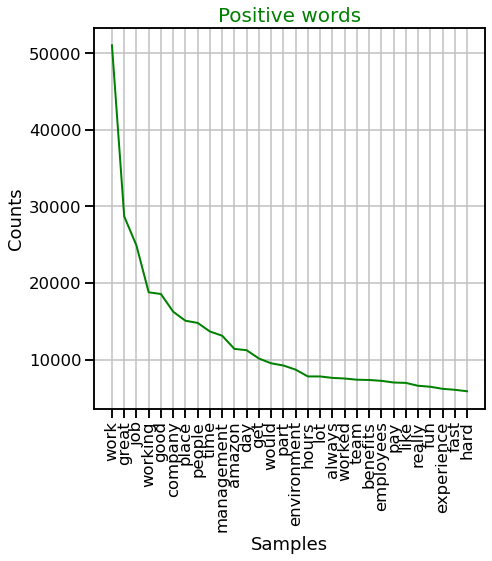

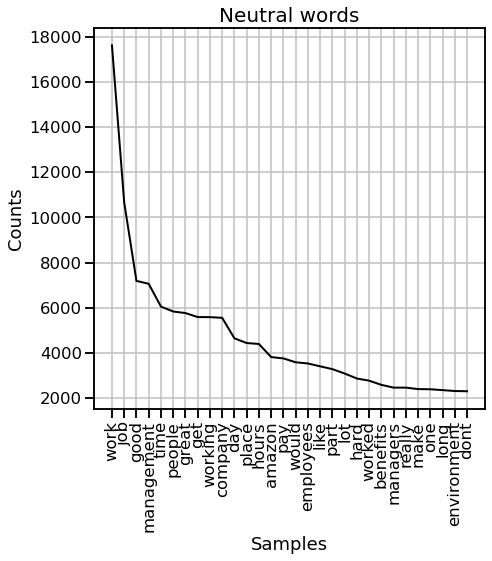

<AxesSubplot:title={'center':'Neutral words'}, xlabel='Samples', ylabel='Counts'>

In [37]:
fdist=FreqDist(flat_list_negative_words)
plt.figure(figsize=(7, 7))
plt.title('Negative words', fontsize=20, c='red')
fdist.plot(30, color='red')


fdist=FreqDist(flat_list_positive_words)
plt.figure(figsize=(7, 7))
plt.title('Positive words', fontsize=20, c='green')
fdist.plot(30, color='green')


fdist=FreqDist(flat_list_neutral_words)
plt.figure(figsize=(7, 7))
plt.title('Neutral words', fontsize=20, c='black')
fdist.plot(30, color='black')


> **A placeholder for me to write down my conclusions based on the dist plots above

## Various ways to tokenize and clean-up text data

### Sample review

In [38]:
review_sample = corpus.iloc[1043].body
review_sample

'Place is completely rate driven. The errors basically do not matter as long as you are fast. Unless you work in quality. In that case you must be fast and perfect. There are some great people that work there. The policies need a major overhaul though. Time off is easy to request but you won\'t get much of it. The policy regarding overtime scheduling and schedule changes is ever changing. Sometimes your OT notice is a "Hey you have 12hrs of OT to work tomorrow. See ya then." It is a major killer of weekend plans, appointments, and anything else you thought you were doing. The whole place is geared around perfection and speed and no one needing time off ever and always being available to work that extra time. The lack of planning for human error in the work flow causes more errors and of course everyone working there is human and has a life outside of work that they do need to be present for. No pay is worth a last minute notice that you have been scheduled for OT and that family time y

In [39]:
rating_sample = corpus.iloc[1043].target
rating_sample

'1'

In [40]:
class MyTokenizer:
    """Custom Tokenizer"""
    
    def __init__(self, dict_replace={' OT ': ' overtime ', ' HR ':' human resources ' },
                 stopwords=sw2, punct_custom=string.punctuation.replace('$',''),
                 print_=False, plot_=False, n=30):
        self.tokens = []
        self._dict_replace = dict_replace
        self._stopwords = stopwords
        self._punct_custom = punct_custom
        self._print = print_
        self._plot = plot_
        self._n = n
        self._index = 0

        
    def tokenize(self, obj):
        
        for old, new in self._dict_replace.items():
            obj = obj.replace(old, new)

            
        obj=obj.lower()

        tokens=obj.split(' ')
        tokens

#         self.tokens = [word.lower() for word in tokens]
        self.tokens = [word for word in tokens]
#        print(self.tokens)
        self.tokens = [s.translate(str.maketrans('', '', self._punct_custom))\
                  for s in self.tokens]
#        print(self.tokens)
        self.tokens = [token for token in self.tokens if\
                  token not in self._stopwords]
#        print(self.tokens)
        self.tokens = [s.translate(str.maketrans('', '', '0123456789')) \
                  for s in self.tokens]
#        print(self.tokens)
        self.tokens = [s for s in self.tokens if s != '']
#        print(self.tokens)
        result=self.tokens
        
        if self._print:
            print(f"The original token list has {len(set(tokens))} words")
            print(f"After the full manual cleanup, the review word list has {len(set(self.tokens))} unique words")
        
        if self._plot:
            fdist = FreqDist(self.tokens)
            plt.figure(figsize=(7, 7))
            fdist.plot(self._n);
        return result
             
    def __iter__(self):
        return self
    
    def __next__(self):
        if self._index < len(self.tokens):
            result = self.tokens[self._index]
            self._index+=1
            raise StopIterration
            return result

In [41]:
tk = MyTokenizer()

In [42]:
gfg='We are winning OT !$% 5671'
geek=tk.tokenize(gfg)
print('finally it worked',geek)

finally it worked ['winning', 'overtime', '$']


### Manual minimal pre-processing

In [43]:
MyTK=MyTokenizer(print_=True, plot_=True, stopwords=sw2)

The original token list has 169 words
After the full manual cleanup, the review word list has 113 unique words


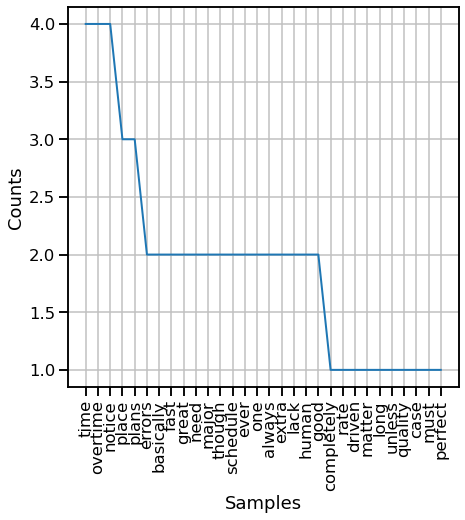

In [44]:
testMyTK=MyTK.tokenize(review_sample)

The original token list has 178 words
After the full manual cleanup, the review word list has 113 unique words


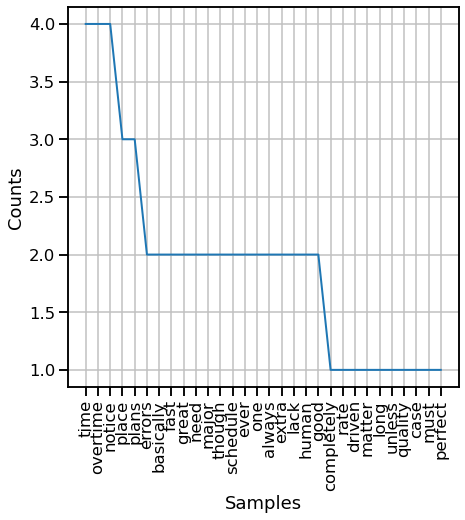

In [45]:
corpus_body_element_cleaned_man=manual_cleanup(review_sample, dict_replace, sw=sw2)

### Tokenization, no lemmatization

#### MyTokenizer

After using


 our sample review has 113 unique words


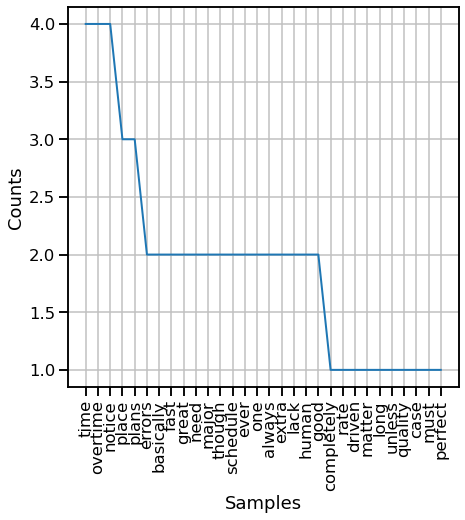

In [46]:
list_of_words_mytoken=review_tokenize_only(review_sample, MyTokenizer(), dict_replace, sw2)

#### RegExTokenizer

After using

 RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)

 our sample review has 111 unique words


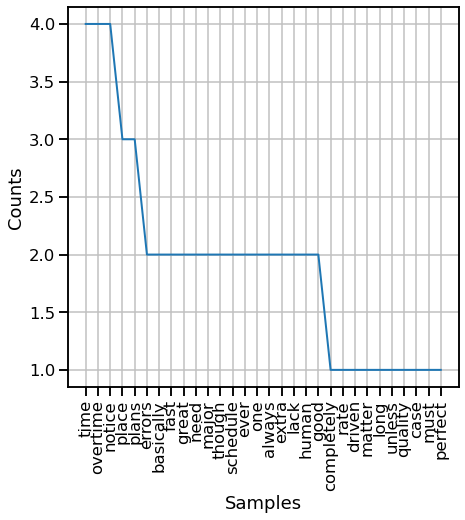

In [47]:
list_of_words_regex=review_tokenize_only(review_sample, RegexpTokenizer(pattern), dict_replace, sw2)

#### TreebankWordTokenizer

After using


 our sample review has 128 unique words


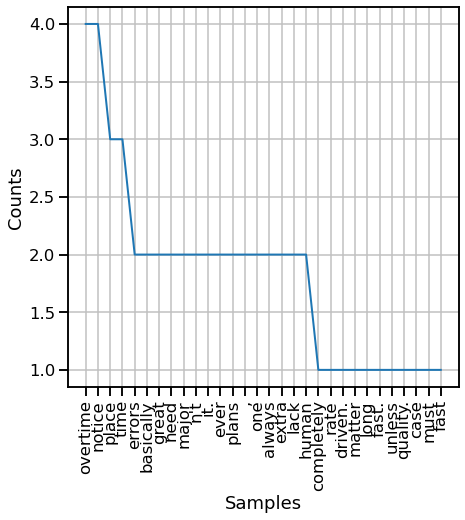

In [48]:
list_of_words_TreeBanktokenize=review_tokenize_only(review_sample, TreebankWordTokenizer(), dict_replace, sw2)

TreeBankTokenizer for some reason left a space behind

### Tokenization with lemmatization

#### MyTokenizer & WordNetLemmatizer

After using

&
<WordNetLemmatizer>

 our sample review has 106 unique lemmas


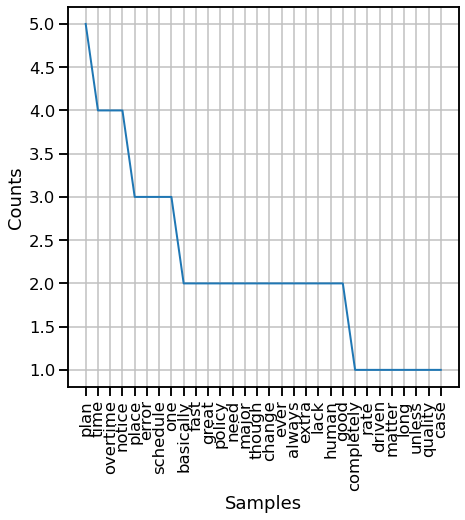

In [49]:
list_of_words_treebank_wordnet=review_tokenize_lemmatize(review_sample, MyTokenizer(), WordNetLemmatizer(), 
                                                         dict_replace, sw2)

#### TreeBankWordTokenizer & WordNetLemmatizer

After using

&
<WordNetLemmatizer>

 our sample review has 122 unique lemmas


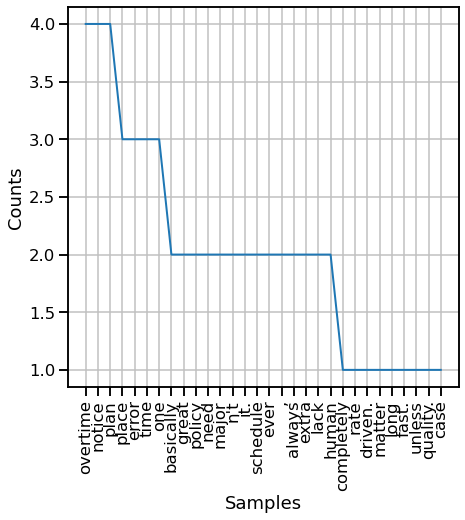

In [50]:
list_of_words_treebank_wordnet=review_tokenize_lemmatize(review_sample, TreebankWordTokenizer(), WordNetLemmatizer(), 
                                                         dict_replace, sw2)

#### RegExTokenizer & WordNetLemmatizer

After using

 RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)
&
<WordNetLemmatizer>

 our sample review has 104 unique lemmas


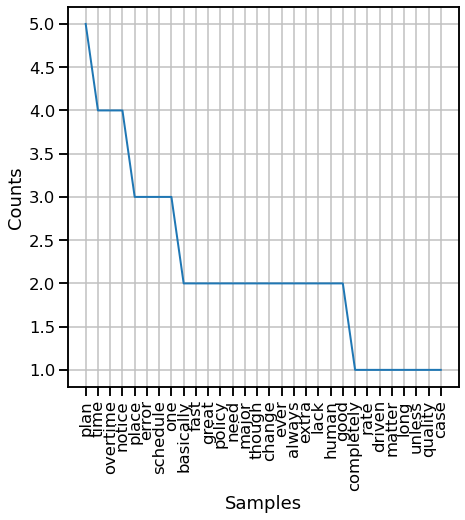

In [51]:
list_of_words_regex_wordnet=review_tokenize_lemmatize(review_sample, RegexpTokenizer(pattern), WordNetLemmatizer(),
                                                      dict_replace, sw2)

### Comparing time for a phrase processing

In [52]:
regex_tok=RegexpTokenizer(pattern)
my_tok=MyTokenizer()
treebank_tok=TreebankWordTokenizer()

In [53]:
text1=regex_tok.tokenize(review_sample)

In [54]:
text2=my_tok.tokenize(review_sample)

In [55]:
text3=treebank_tok.tokenize(review_sample)

> RegExTokenizer is the fastest one while MyTokenizer is the slowest.

### Splitting and processing the corpus

In [56]:
text_from_first_option=' '.join(review_tokenize_lemmatize(review_sample, MyTokenizer(), WordNetLemmatizer(),
                                                      dict_replace, sw2,plot_=False,print_=False))
text_from_first_option

'place completely rate driven error basically matter long fast unless quality case must fast perfect great people policy need major overhaul though time easy request wont get much policy regard overtime scheduling schedule change ever change sometimes overtime notice hey hrs overtime tomorrow see ya major killer weekend plan appointment anything else think place gear around perfection speed one needing time ever always available extra time lack plan human error flow cause error course everyone work human life outside need present pay worth last minute notice schedule overtime family time plan cancel tell give day notice dont always default old memo say basically hr notice require extra shift even modify regular schedule insurance plan offer though actually really good hoop jump one great plan awesome coworkers good benefit place go look normal big company office politics absolute lack concern one entry'

In [57]:
text_from_second_option=[' '.join(review_tokenize_lemmatize(review_sample, RegexpTokenizer(pattern), WordNetLemmatizer(),
                                                      dict_replace, sw2,plot_=False,print_=False))]
text_from_second_option

['place completely rate driven error basically matter long fast unless quality case must fast perfect great people policy need major overhaul though time easy request get much policy regard overtime scheduling schedule change ever change sometimes overtime notice hey hrs overtime tomorrow see ya major killer weekend plan appointment anything else think place gear around perfection speed one needing time ever always available extra time lack plan human error flow cause error course everyone work human life outside need present pay worth last minute notice schedule overtime family time plan cancel tell give day notice always default old memo say basically hr notice require extra shift even modify regular schedule insurance plan offer though actually really good hoop jump one great plan awesome coworkers good benefit place go look normal big company office politics absolute lack concern one entry']

In [58]:
text_from_third_option=' '.join(review_tokenize_lemmatize(review_sample, TreebankWordTokenizer(), WordNetLemmatizer(),
                                                      dict_replace, sw2,plot_=False,print_=False))
text_from_third_option

"place completely rate driven. error basically matter long fast. unless quality. case must fast perfect. great people there. policy need major overhaul though. time easy request wo n't get much it. policy regard overtime scheduling schedule change ever changing. sometimes overtime notice `` hey 12hrs overtime tomorrow. see ya then. '' major killer weekend plan , appointment , anything else think doing. place gear around perfection speed one needing time ever always available extra time. lack plan human error flow cause error course everyone work human life outside need present for. pay worth last minute notice schedule overtime family time plan cancelled. tell give 7 day notice n't always default old memo say basically 24hr notice required. extra shift even modify regular schedule. insurance plan offer though actually really good. hoop jump one great plans. awesome coworkers good benefit place go it. look normal big company office politics absolute lack concern one entry"

## Feature Engineering, Vectorization

### Testing vectorizers

In [59]:
df_eda.tokens[0:10]

0    [worked, contractor, two, years, never, hired,...
1             [worst, place, ive, ever, worked, hands]
2    [compnay, good, benefits, even, small, pension...
3    [company, life, work, balance, everyday, full,...
4    [long, work, ball, drive, work, long, since, l...
5    [i’ve, watched, ball, morph, management, strat...
6    [great, job, little, disorganized, job, isn’t,...
7    [management, company, clueless, high, work, lo...
8    [ball, old, reputation, great, company, reputa...
9    [never, know, kind, day, going, work, days, re...
Name: tokens, dtype: object

In [60]:
sw3=['ـــ',
 '⅞you',
 'いい経験でした',
 'いろいろな安全手順を守って',
 'チームの雰囲気はよかったです',
 '一ヶ月ぐらいだったけど',
 '仕事は海軍の時の同じで',
 '但是内部族裔斗争激烈',
 '但是能在年左右对财务方面有非常大的长进',
 '偶尔通宵',
 '工作量大', '晚上十点下班是正常的', 'ànd',
 'àreas',
 'ámbito',
 'área',
 'áreas',
 'çektiği',
 'échelle',
 'également',
 'él',
 'época',
 'époque',
 'équipe',
 'équipes',
 'ésta',
 'était',
 'ética',
 'étonnant',
 'évolutions',
 'ídolos',
 'índole',
 'óptimas',
 'ótima',
 'últimamente',
 'último',
 'única',
 'único',
 'únicome',
 'útil',
 'čtrnácti',
 'środka',
 'świata',
 'świetnie','正常积极地展现自己']

#### Vectorizers with MyTokenizer

In [61]:
# reviews_cleaned_mytokenizer=[]
# reviews_cleaned_mytokenizer=[' '.join(review_tokenize_lemmatize(str(review), MyTokenizer(), WordNetLemmatizer(),dict_replace, 
#                                                     sw2,plot_=False,print_=False)) for review in df_eda.tokens]

# with open('review_cleaned_mytokenizer.pkl', 'wb') as f:
#     pickle.dump(reviews_cleaned_mytokenizer, f)

In [62]:
with open('review_cleaned_mytokenizer.pkl', 'rb') as f:
    reviews_cleaned_mytokenizer = pickle.load(f)

In [63]:
len(reviews_cleaned_mytokenizer)

121620

##### CountVectorizer

In [64]:
vec_my1=CountVectorizer(stop_words=sw3)
text_vec_my1=vec_my1.fit_transform(reviews_cleaned_mytokenizer)

In [65]:
# feat_col=vec1.get_feature_names()
# feat_col[-32:]

In [66]:
# df_vec_my1=pd.DataFrame(text_vec_my1.todense(), columns=vec_my1.get_feature_names())
# df_vec_my1=df_vec_my1.sample(frac=0.01)
# df_vec_my1.to_pickle('df_vec_my1.pkl')

In [67]:
df_vec_my1=pd.read_pickle('df_vec_my1.pkl')
df_vec_my1

,aa,aaa,aaaannnddd,aaeak,aag,aaked,aal,aalarm,aalways,aam,...,zoom,zoothis,zos,zpdt,zsecure,ztpf,zu,zulily,zurich,zyrtec
113946,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### TfIdfVectorizer

In [68]:
vec_my2=TfidfVectorizer(stop_words=sw3)
text_vec_my2=vec_my2.fit_transform(reviews_cleaned_mytokenizer)

In [69]:
# df_vec_my2=pd.DataFrame(text_vec_my2.todense(), columns=vec_my2.get_feature_names())
# df_vec_my2=df_vec_my2.sample(frac=0.01)
# df_vec_my2.to_pickle('df_vec2_my.pkl')

In [70]:
df_vec_my2=pd.read_pickle('df_vec2_my.pkl')
df_vec_my2

,aa,aaa,aaaannnddd,aaeak,aag,aaked,aal,aalarm,aalways,aam,...,zoom,zoothis,zos,zpdt,zsecure,ztpf,zu,zulily,zurich,zyrtec
26972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Vectorizers with RegExTokenizer

In [71]:
# reviews_cleaned_regextokenizer=[]
# reviews_cleaned_regextokenizer=[' '.join(review_tokenize_lemmatize(str(review), RegexpTokenizer(pattern), WordNetLemmatizer(),dict_replace, 
#                                                     sw2,plot_=False,print_=False)) for review in df_eda.tokens]

# with open('review_cleaned_regextokenizer.pkl', 'wb') as f:
#     pickle.dump(reviews_cleaned_regextokenizer, f)

In [72]:
with open('review_cleaned_regextokenizer.pkl', 'rb') as f:
    reviews_cleaned_regextokenizer = pickle.load(f)

In [73]:
len(reviews_cleaned_regextokenizer)

121620

##### CountVectorizer

In [74]:
vec_regex1=CountVectorizer(stop_words=sw3)
text_vec_regex1=vec_regex1.fit_transform(reviews_cleaned_regextokenizer)

In [75]:
# df_vec_regex1=pd.DataFrame(text_vec_regex1.todense(), columns=vec_regex1.get_feature_names())
# df_vec_regex1=df_vec_regex1.sample(frac=0.01)
# df_vec_regex1.to_pickle('df_vec_regex1.pkl')

In [76]:
df_vec_regex1=pd.read_pickle('df_vec_regex1.pkl')
df_vec_regex1

,aa,aaa,aaaannnddd,aaeak,aag,aaked,aal,aalarm,aalways,aam,...,zoothis,zos,zpdt,zsecure,ztpf,zu,zulily,zurich,zyka,zyrtec
113946,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### TfIdfVectorizer

In [77]:
vec_regex2=TfidfVectorizer(stop_words=sw3)
text_vec_regex2=vec_regex2.fit_transform(reviews_cleaned_regextokenizer)

In [78]:
# df_vec_regex2=pd.DataFrame(text_vec_regex2.todense(), columns=vec_regex2.get_feature_names())
# df_vec_regex2=df_vec_regex2.sample(frac=0.01)
# df_vec_regex2.to_pickle('df_vec_regex2.pkl')

In [79]:
df_vec_regex2=pd.read_pickle('df_vec_regex2.pkl')
df_vec_regex2

,aa,aaa,aaaannnddd,aaeak,aag,aaked,aal,aalarm,aalways,aam,...,zoothis,zos,zpdt,zsecure,ztpf,zu,zulily,zurich,zyka,zyrtec
26972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> They all work just fine so I can go ahead with modeling

### Creating and vectorizing training, test and validation sets

#### Splitting into training, test and validation sets

In [80]:
X=df_eda.tokens
y=df_eda.target

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=123,
                                                    test_size=0.25)

In [82]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

91215 30405 91215 30405


In [83]:
# token_reviews=[' '.join(review_tokenize_lemmatize(str(review), RegexpTokenizer(pattern), WordNetLemmatizer(),dict_replace, 
#                                                      sw2,plot_=False,print_=False)) for review in X_train]

# with open('token_reviews.pkl', 'wb') as f:
#     pickle.dump(token_reviews, f)

In [84]:
with open('token_reviews.pkl', 'rb') as f:
    token_reviews = pickle.load(f)

In [85]:
len(token_reviews)

91215

In [86]:
token_reviews[10000]

'meat department busy department everyone give didnt upper management would tell policy immediate supervisor would contradict vice versa'

In [87]:
# Splitting X_Training into main training and validation sets

X_main_train, X_val, y_main_train, y_val = train_test_split(token_reviews,
                                                                        y_train,
                                                                        random_state=123,
                                                                        test_size=0.25)

In [88]:
len(X_main_train)

68411

#### Vectorization of the sets

##### CountVectorizer

In [89]:
vec_count=CountVectorizer(stop_words=sw3)
vec_count_X_train=vec_count.fit_transform(X_main_train)

In [90]:
# df_vec_count_train=pd.DataFrame(vec_count_X_train.todense(), columns=vec_count.get_feature_names())
# df_vec_count_train.set_index(y_main_train.index, inplace=True)
# df_vec_count_train.info()

In [91]:
a=list(vec_count.vocabulary_.values())
b=list(vec_count.vocabulary_.keys())
print(a[:50], b[:50])

[33109, 21463, 17065, 11209, 15706, 22735, 12422, 21290, 32039, 22166, 32873, 24028, 27083, 10754, 19346, 23963, 9459, 26976, 8209, 17758, 22244, 5406, 23367, 5542, 31584, 13890, 26317, 21055, 5237, 31979, 5907, 5242, 1663, 19286, 11032, 16593, 25357, 5727, 1305, 9237, 28402, 19643, 24728, 10994, 8091, 17032, 17448, 2965, 12219, 8325] ['young', 'people', 'look', 'first', 'job', 'pretty', 'good', 'pay', 'weekly', 'plus', 'would', 'recommend', 'someone', 'family', 'nice', 'recently', 'enforcement', 'social', 'distancing', 'mask', 'policy', 'company', 'punish', 'complain', 'violate', 'hour', 'shift', 'pandemic', 'combined', 'wear', 'constantly', 'come', 'area', 'never', 'felt', 'less', 'safe', 'conduct', 'annual', 'employee', 'survey', 'nothing', 'responses', 'feedback', 'dishearten', 'long', 'management', 'best', 'get', 'do']


In [92]:
vec_count_X_val=vec_count.transform(X_val)

In [93]:
# df_vec_count_val=pd.DataFrame(vec_count_X_val.todense(), columns=vec_count.get_feature_names())
# df_vec_count_val.set_index(y_val.index, inplace=True)
# df_vec_count_val.info()

##### TfIdfVectorizer

In [94]:
vec_tfidf=TfidfVectorizer(stop_words=sw3)
vec_tfidf_X_train=vec_tfidf.fit_transform(X_main_train)

In [95]:
# df_vec_tfidf_train=pd.DataFrame(vec_tfidf_X_train.todense(), columns=vec_tfidf.get_feature_names())
# df_vec_tfidf_train.set_index(y_main_train.index, inplace=True)
# df_vec_tfidf_train.info()

In [96]:
vec_tfidf_X_val=vec_tfidf.transform(X_val)

In [97]:
# df_vec_tfidf_val=pd.DataFrame(vec_tfidft_X_val.todense(), columns=vec_tfidf.get_feature_names())
# df_vec_tfidf_val.set_index(y_val.index, inplace=True)
# df_vec_tfidf_val.info()

# Model

In [98]:
datasets_list_count_val=[vec_count_X_train, vec_count_X_val, y_main_train, y_val]
datasets_list_tfidf_val=[vec_tfidf_X_train, vec_tfidf_X_val, y_main_train, y_val]
models_dict={'Classifier Name':[], 'Description':[],'Training or Val/Test': [],
             'Accuracy':[],'F1 Score':[], 'Saved model':[]}

## Default parameters models

### DummyClassifier model

In [99]:
#Building a dummy model with DummyClassifier.

dummy_num_model=DummyClassifier(strategy='most_frequent')
dummy_num_model.fit(vec_count_X_train,y_main_train)

DummyClassifier(strategy='most_frequent')

In [100]:
y_hat=dummy_num_model.predict(vec_count_X_val)
accuracy_score(y_val,y_hat)
f1_score(y_val, y_hat, average="weighted")

0.426699952872438

***************************************
DummyClassifier(strategy='most_frequent')
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     13360
           2       0.00      0.00      0.00     15112
           3       0.58      1.00      0.74     39939

    accuracy                           0.58     68411
   macro avg       0.19      0.33      0.25     68411
weighted avg       0.34      0.58      0.43     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      4489
           2       0.00      0.00      0.00      5072
           3       0.58      1.00      0.73     13243

    accuracy                           0.58     22804
   macro avg       0.19      0.33      0.24     22804
weig

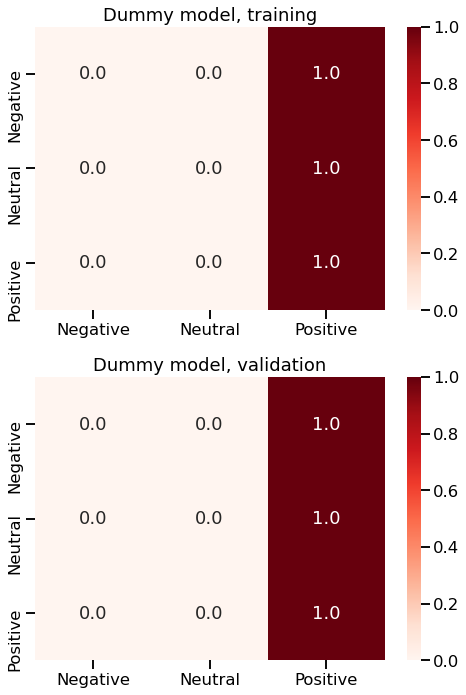

In [101]:
simple_model_validation(dummy_num_model, datasets_list_count_val, 'Dummy model, training', 'Dummy model, validation')

In [102]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'Dummy  with CountVectorizer',
                                         'dummy_num_model',
                                         datasets_list_count_val, 
                                         dummy_num_model,
                                         'not saved')

In [103]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved


In [104]:
del models_df

### MultinomialNB model

In [105]:
mnb1=MultinomialNB()

mnb1.fit(vec_count_X_train,y_main_train)
cross_val_score(mnb1, vec_count_X_train,y_main_train, cv=5, scoring='f1_macro')

array([0.56937929, 0.56825015, 0.57870884, 0.56253266, 0.56795986])

In [106]:
mnb1.classes_

array(['1', '2', '3'], dtype='<U1')

In [107]:
prior_1=y_train.value_counts()[0]/len(y_train)
prior_2=y_train.value_counts()[1]/len(y_train)
prior_3=y_train.value_counts()[2]/len(y_train)
print(round(prior_1,4), round(prior_2,4), round(prior_3,4))

0.583 0.2213 0.1957


***************************************
MultinomialNB()
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.66      0.69      0.68     13360
           2       0.55      0.35      0.43     15112
           3       0.79      0.88      0.83     39939

    accuracy                           0.73     68411
   macro avg       0.66      0.64      0.64     68411
weighted avg       0.71      0.73      0.71     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.60      0.65      0.62      4489
           2       0.38      0.23      0.28      5072
           3       0.76      0.86      0.80     13243

    accuracy                           0.67     22804
   macro avg       0.58      0.58      0.57     22804
weighted avg       0.64      0

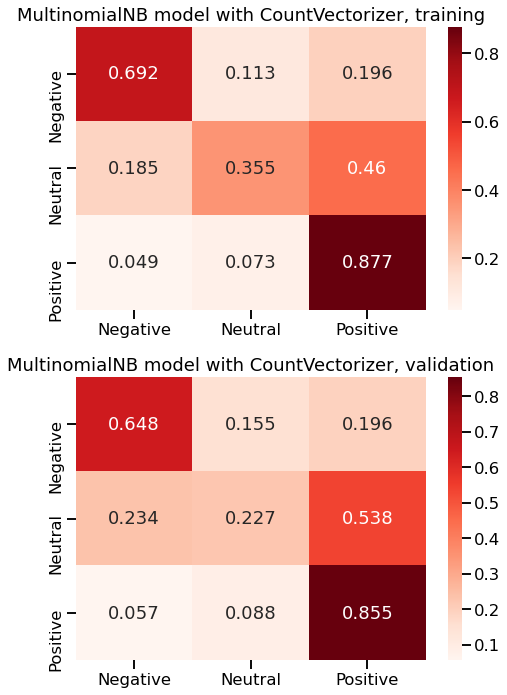

In [108]:
simple_model_validation(mnb1, datasets_list_count_val, 'MultinomialNB model with CountVectorizer, training',
                        'MultinomialNB model with CountVectorizer, validation')

In [109]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'MultinomialNB model with CountVectorizer',
                                         'mnb1',
                                         datasets_list_count_val, 
                                         mnb1,
                                         'not saved; fast fitting')

In [110]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting


### LogisticRegressionCV

#### With CountVectorized set

In [111]:
# lrcv1=LogisticRegressionCV(max_iter=1000, random_state=123, scoring='f1_macro')
# lrcv1.fit(vec_count_X_train,y_main_train)

In [112]:
# filename = 'models/LRCV_count_fitted.pkl'
# pickle.dump(lrcv1, open(filename, 'wb'))

In [113]:
filename = 'models/LRCV_count_fitted.pkl'
lrcv1_loaded_model = pickle.load(open(filename, 'rb'))

***************************************
LogisticRegressionCV(max_iter=1000, random_state=123, scoring='f1_macro')
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.78      0.68      0.73     13360
           2       0.68      0.37      0.48     15112
           3       0.77      0.94      0.85     39939

    accuracy                           0.76     68411
   macro avg       0.74      0.66      0.68     68411
weighted avg       0.75      0.76      0.74     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.65      0.57      0.61      4489
           2       0.38      0.19      0.26      5072
           3       0.73      0.90      0.81     13243

    accuracy                           0.68     22804
   macro avg       0.58   

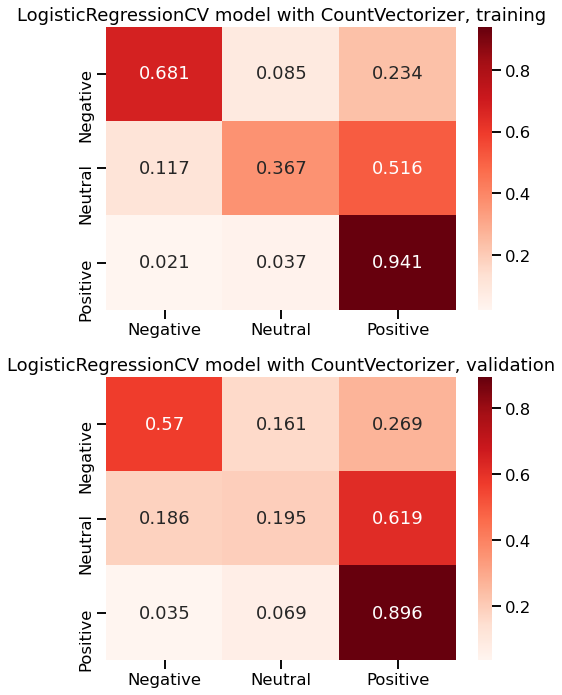

In [114]:
simple_model_validation(lrcv1_loaded_model, datasets_list_count_val,
                        'LogisticRegressionCV model with CountVectorizer, training',
                        'LogisticRegressionCV model with CountVectorizer, validation')

In [115]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'LogisticRegressionCV model with CountVectorizer',
                                         'lrcv1_loaded_model',
                                         datasets_list_count_val, 
                                         lrcv1_loaded_model,
                                         'models/LRCV_count_fitted.pkl')

In [116]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl


#### With TfIdfVectorized set

In [117]:
# lrcv2=LogisticRegressionCV(max_iter=400, random_state=123, n_jobs=-1, scoring='f1_macro')
# lrcv2.fit(vec_tfidf_X_train,y_main_train)

# filename = 'models/LRCV_tfidf_fitted.pkl'
# pickle.dump(lrcv2, open(filename, 'wb'))

In [118]:
filename = 'models/LRCV_tfidf_fitted.pkl'
lrcv2_loaded_model = pickle.load(open(filename, 'rb'))

***************************************
LogisticRegressionCV(max_iter=400, n_jobs=-1, random_state=123,
                     scoring='f1_macro')
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.77      0.71      0.74     13360
           2       0.69      0.40      0.50     15112
           3       0.79      0.94      0.86     39939

    accuracy                           0.77     68411
   macro avg       0.75      0.68      0.70     68411
weighted avg       0.76      0.77      0.76     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.63      0.59      0.61      4489
           2       0.38      0.20      0.27      5072
           3       0.74      0.88      0.81     13243

    accuracy                           0.68     2

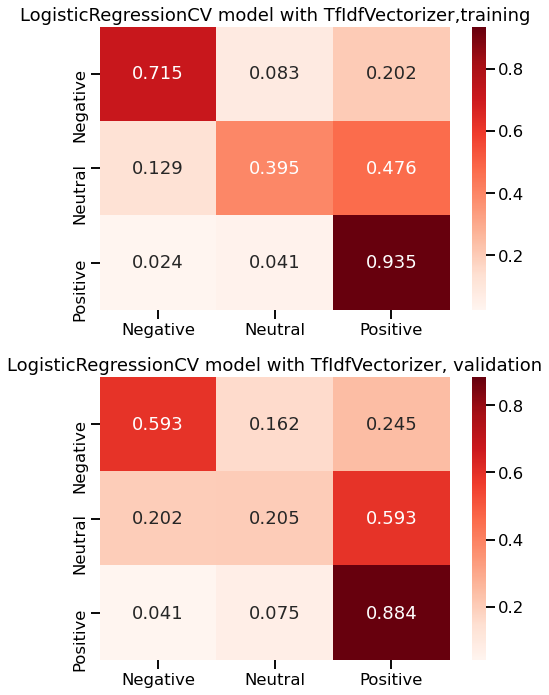

In [119]:
simple_model_validation(lrcv2_loaded_model, datasets_list_tfidf_val,
                        'LogisticRegressionCV model with TfIdfVectorizer,training',
                        'LogisticRegressionCV model with TfIdfVectorizer, validation')

In [120]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'LogisticRegressionCV model with TfIdfVectorizer',
                                         'lrcv2_loaded_model',
                                         datasets_list_tfidf_val, 
                                         lrcv2_loaded_model,
                                         'models/LRCV_tfidf_fitted.pkl')

In [121]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl


### XGBClassifier

#### With CountVectorized set

In [122]:
xgb1=XGBClassifier(multi='softmax', verbosity=0, njobs=-1, seed=123, scoring='f1_macro')

xgb1.fit(vec_count_X_train,y_main_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              multi='softmax', n_estimators=100, n_jobs=16, njobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              scoring='f1_macro', seed=123, subsample=1, tree_method='exact',
              validate_parameters=1, ...)

***************************************
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              multi='softmax', n_estimators=100, n_jobs=16, njobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              scoring='f1_macro', seed=123, subsample=1, tree_method='exact',
              validate_parameters=1, ...)
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.77      0.58      0.66     13360
           2       0.70      0.22      0.

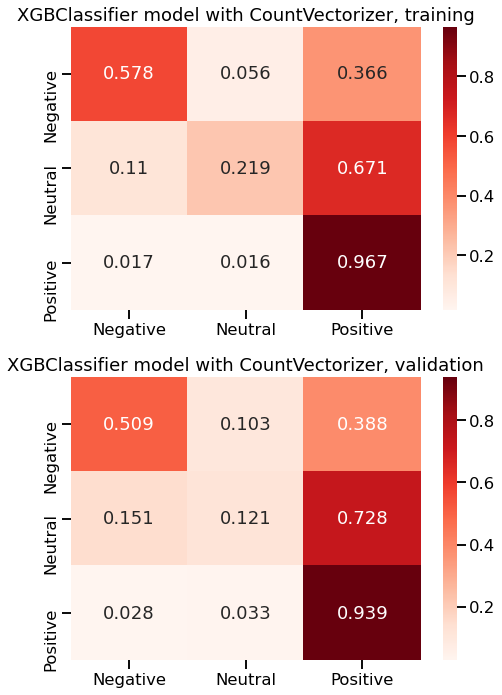

In [123]:
simple_model_validation(xgb1, datasets_list_count_val,
                        'XGBClassifier model with CountVectorizer, training',
                        'XGBClassifier model with CountVectorizer, validation')

In [124]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'XGBClassifier model with CountVectorizer',
                                         'xgb1',
                                         datasets_list_count_val, 
                                         xgb1,
                                         'not saved; fast fitting')

In [125]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl
8,xgb1,XGBClassifier model with CountVectorizer,training,0.726,0.606,not saved; fast fitting
9,xgb1,XGBClassifier model with CountVectorizer,val/test,0.726,0.522,not saved; fast fitting


#### With TfIdfVectorized set

In [126]:
xgb2=XGBClassifier(multi='softmax', seed=123, verbosity=0, njobs=-1, scoring='f1_macro')
xgb2.fit(vec_tfidf_X_train,y_main_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              multi='softmax', n_estimators=100, n_jobs=16, njobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              scoring='f1_macro', seed=123, subsample=1, tree_method='exact',
              validate_parameters=1, ...)

***************************************
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              multi='softmax', n_estimators=100, n_jobs=16, njobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              scoring='f1_macro', seed=123, subsample=1, tree_method='exact',
              validate_parameters=1, ...)
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.77      0.60      0.68     13360
           2       0.75      0.24      0.

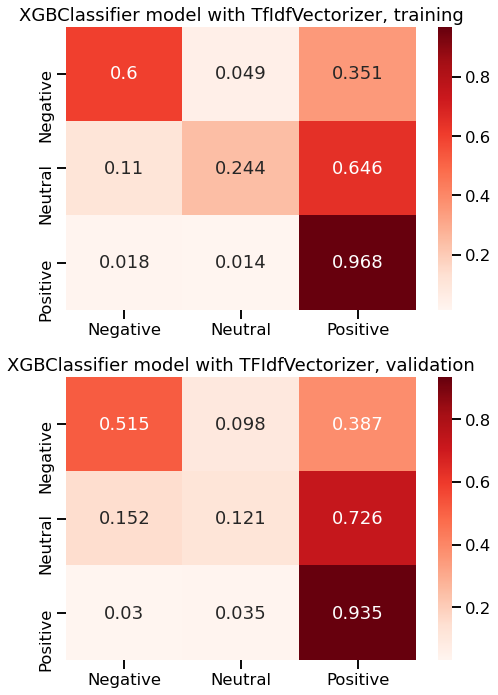

In [127]:
simple_model_validation(xgb2, datasets_list_tfidf_val,
                        'XGBClassifier model with TfIdfVectorizer, training',
                        'XGBClassifier model with TFIdfVectorizer, validation')

In [128]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'XGBClassifier model with TFIdfVectorizer',
                                         'xgb2',
                                          datasets_list_tfidf_val, 
                                          xgb2,
                                         'not saved; fast fitting')

In [129]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl
8,xgb1,XGBClassifier model with CountVectorizer,training,0.726,0.606,not saved; fast fitting
9,xgb1,XGBClassifier model with CountVectorizer,val/test,0.726,0.522,not saved; fast fitting


### Conclusion

None of the models performed particularly well:
* MultinomialNB model with CountVectoried dataset was very fast but performed slightly worse than LogisticRegression models (both count-vectorized and tdidf-vectorized) in terns of accuracy
* MultinomialNB model has the best ability to identify Neutral reviews, which seems to be a problem for other models.
* Logistic regression models took the most time to train but produced better results.
* MultinomialNB model does not have many parameters to tune the model except the alpha smoothing parameter
* Logistic regression can be tuned up on many more parameters but the time running each variation might become prohibitive.
* XGBClassifier models (both count-vectorized and tdidf-vectorized) perfomed slightly worse than MultinomialNB model. However, XGBCalssifier has more hyperparameters to tune it and therefore might be a good candidate for a grid search considering relatively short time to run the fit.

>* The final choice is to run a grid search for
>> * MultinomialNB classifier
>>> alpha hyperparameter in MultinomialNB classifier
>> * XGBoostCalssifier
>>> booster (gbtree)<br>
>>> gamma (0, 0.1, 1, 10)<br>
>>> eta (aka learning rate) (0.1, 0.5, 1)<br>
>>> subsample (0.1, 0.5,0.7, 1)<br>
>>> sampling method (uniform, gradient_based)<br>
>>> tree_method (approx, hist, gpu_hist)<br>
>>> lambda (0,1)<br>
>>> alpha (0,1)<br>


## GridSearch for Best Models

### GridsearchCV for XGBClassifier with count-vectorized dataset

In [130]:
# params = {'eta': [0.1, 0.5, 1],
#           'gamma':[0, 0.1, 1, 10],
#           'lambda':[0,1],
#            'alpha': [0,1],
#            'subsample': [0.1, 0.5, 0.7, 1], 'sampling_method': ['uniform', 'gradient_based'],
#            'tree_method': ['approx', 'hist', 'gpu_hist']}


# gridsearch = GridSearchCV(XGBClassifier(multi='softmax', random_state=123, booster='gbtree'), params, n_jobs=-1,
#                           cv=3, verbose=0, scoring = 'f1_macro')

# gridsearch.fit(vec_count_X_train, y_main_train)

> This gridsearch ran for 1.5 hour so it is pretty expensive computationally

In [131]:
# joblib.dump(gridsearch.best_estimator_, 'models/XGB_best.joblib')

In [132]:
# gridsearch.best_score_

In [133]:
# gridsearch.best_params_

In [134]:
# xgb5=XGBClassifier(multi='softmax', verbosity=0, njobs=-1, seed=123,
#                    booster='gbtree',
#                    eta=1,
#                    gamma=0.1,
#                    reg_lambda=1,
#                    reg_alpha=1,
#                    sampling_method='uniform',
#                    subsample=0.7,
#                    tree_method='hist',
#                    scoring='f1_macro')

# xgb5.fit(vec_count_X_train,y_main_train)

In [135]:
# filename = 'models/XGB_best_count_fitted.pkl'
# pickle.dump(xgb5, open(filename, 'wb'))

In [136]:
filename = 'models/XGB_best_count_fitted.pkl'
xgb5_loaded_model = pickle.load(open(filename, 'rb'))

***************************************
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=1, gamma=0.1,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              multi='softmax', n_estimators=100, n_jobs=16, njobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=123,
              reg_alpha=1, reg_lambda=1, sampling_method='uniform',
              scale_pos_weight=None, scoring='f1_macro', seed=123,
              subsample=0.7, ...)
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.78      0.67      0.72     13360
           2       0.70      0.40      0.51     15112
   

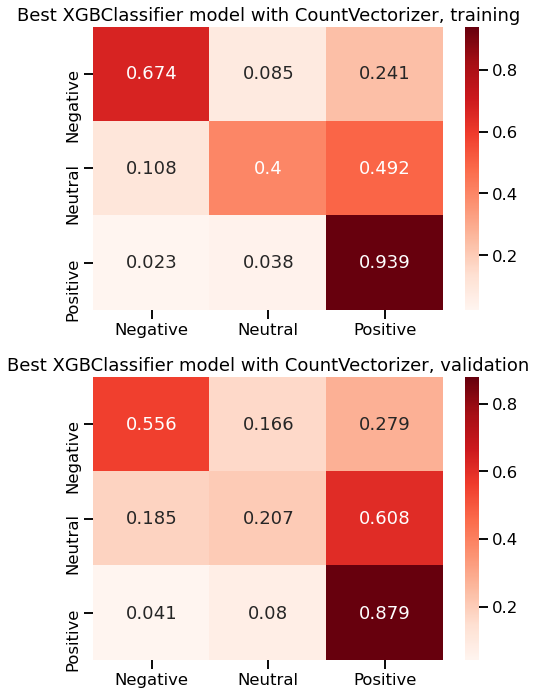

In [137]:
simple_model_validation(xgb5_loaded_model, datasets_list_count_val,
                        'Best XGBClassifier model with CountVectorizer, training',
                        'Best XGBClassifier model with CountVectorizer, validation')

In [138]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'Best XGBClassifier model with CountVectorizer',
                                         'xgb5_loaded_model',
                                          datasets_list_count_val, 
                                          xgb5_loaded_model,
                                         'models/XGB_best_count_fitted.pkl')

In [139]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl
8,xgb1,XGBClassifier model with CountVectorizer,training,0.726,0.606,not saved; fast fitting
9,xgb1,XGBClassifier model with CountVectorizer,val/test,0.726,0.522,not saved; fast fitting


### GridSearch for MultinomialNB Classifier

In [140]:
params = {'alpha':[0,0.1,0.3,0.5,0.7, 1]}


gridsearch = GridSearchCV(MultinomialNB(), params, n_jobs=-1,
                          cv=3, verbose=0, scoring = 'f1_macro')

gridsearch.fit(vec_count_X_train, y_main_train)

GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.3, 0.5, 0.7, 1]},
             scoring='f1_macro')

In [141]:
gridsearch.best_score_

0.5771297387176196

In [142]:
gridsearch.best_params_

{'alpha': 0.3}

In [143]:
mnb2=MultinomialNB(alpha=0.3)
mnb2.fit(vec_count_X_train,y_main_train)

MultinomialNB(alpha=0.3)

***************************************
MultinomialNB(alpha=0.3)
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.68      0.71      0.69     13360
           2       0.56      0.45      0.50     15112
           3       0.81      0.86      0.83     39939

    accuracy                           0.74     68411
   macro avg       0.68      0.67      0.67     68411
weighted avg       0.73      0.74      0.73     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.59      0.65      0.62      4489
           2       0.36      0.28      0.31      5072
           3       0.77      0.82      0.79     13243

    accuracy                           0.66     22804
   macro avg       0.58      0.58      0.58     22804
weighted avg       0.

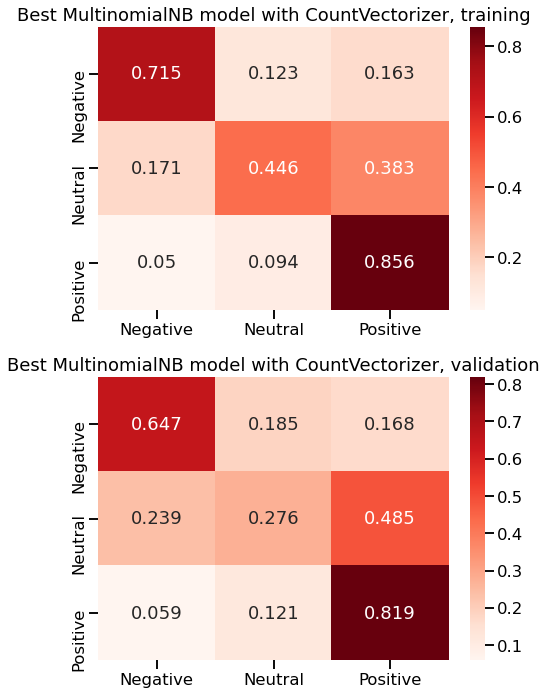

In [144]:
simple_model_validation(mnb2, datasets_list_count_val,
                        'Best MultinomialNB model with CountVectorizer, training',
                        'Best MultinomialNB model with CountVectorizer, validation')

In [145]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'Best MNBClassifier model with CountVectorizer',
                                         'mnb2',
                                          datasets_list_count_val, 
                                          mnb2,
                                         'not saved, fast fitting model')

In [146]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl
8,xgb1,XGBClassifier model with CountVectorizer,training,0.726,0.606,not saved; fast fitting
9,xgb1,XGBClassifier model with CountVectorizer,val/test,0.726,0.522,not saved; fast fitting


### GridSearch for LogisticRegressionCV classifier

In [147]:
# params = {'solver' : ['newton-cg', 'lbfgs', 'sag']}


# gridsearch = GridSearchCV(LogisticRegressionCV(max_iter=400, random_state=123,
#                                                penalty='l2',
#                                                class_weight='balanced',
#                                                multi_class='multinomial'), params, n_jobs=-1,
#                           cv=3, verbose=2, scoring = 'f1_macro')

# gridsearch.fit(vec_tfidf_X_train,y_main_train)

In [148]:
# gridsearch.best_score_

In [149]:
# gridsearch.best_params_

> Due to the fact that the gridsearch ran for close to 20 minutes I am saving the gridsearch.best_estamator to a joblib file. 

In [150]:
# joblib.dump(gridsearch.best_estimator_, 'models/LRCV_best_tfidf.joblib')

In [151]:
# lrcv3=LogisticRegressionCV(max_iter=400, random_state=123,
#                            class_weight='balanced',
#                            multi_class='multinomial',
#                            penalty='l2',
#                            solver='newton-cg',
#                            scoring='f1_macro')
# lrcv3.fit(vec_tfidf_X_train,y_main_train)

> The fitting of the model took 12.5 minutes to fit the data and due to that fact I am saving it to a pickle file to use later.

In [152]:
# filename = 'models/LRCV_best_tfidf_fitted.pkl'
# pickle.dump(lrcv3, open(filename, 'wb'))

In [153]:
filename = 'models/LRCV_best_tfidf_fitted.pkl'
lrcv3_loaded_model = pickle.load(open(filename, 'rb'))

***************************************
LogisticRegressionCV(class_weight='balanced', max_iter=400,
                     multi_class='multinomial', random_state=123,
                     scoring='f1_macro', solver='newton-cg')
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.62      0.76      0.68     13360
           2       0.44      0.53      0.48     15112
           3       0.86      0.73      0.79     39939

    accuracy                           0.69     68411
   macro avg       0.64      0.67      0.65     68411
weighted avg       0.72      0.69      0.70     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.56      0.70      0.62      4489
           2       0.34      0.41      0.37      5072
           3       0.8

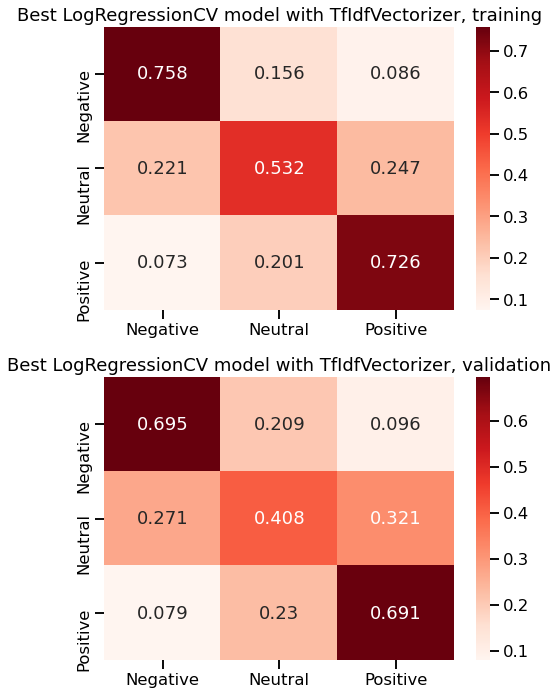

In [154]:
simple_model_validation(lrcv3_loaded_model, datasets_list_tfidf_val,
                        'Best LogRegressionCV model with TfIdfVectorizer, training',
                        'Best LogRegressionCV model with TfIdfVectorizer, validation')

In [155]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'LogRegressionCV model with TfIdfVectorizer, best params',
                                         'lrcv3_loaded_model',
                                         datasets_list_tfidf_val,
                                         lrcv3_loaded_model,
                                         'models/LRCV_best_tfidf_fitted.pkl')

In [156]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl
8,xgb1,XGBClassifier model with CountVectorizer,training,0.726,0.606,not saved; fast fitting
9,xgb1,XGBClassifier model with CountVectorizer,val/test,0.726,0.522,not saved; fast fitting


>The best performing models are 
> * LogRegressionCV model with TfIdfVectorizer, best params<br>
> * Best MNBClassifier model with CountVectorizer

> Both models use the same full features dataset

## Reduction of Features, addition of bigrams

### MNBClassifier

In [157]:
vec_count2=CountVectorizer(stop_words=sw3, min_df=0.01, max_df=0.99, ngram_range=(1, 3))
vec_count2_X_train=vec_count2.fit_transform(X_main_train)


In [158]:
df_vec_count2=pd.DataFrame(vec_count2_X_train.todense(), columns=vec_count2.get_feature_names())
df_vec_count2.head()

,able,actually,advance,advancement,allow,almost,along,alot,also,always,...,worklife,worklife balance,workplace,world,worth,would,would recommend,write,year,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [159]:
vec_count2_X_val=vec_count2.transform(X_val)
df_vec_count2_val=pd.DataFrame(vec_count2_X_val.todense(), columns=vec_count2.get_feature_names())
df_vec_count2_val

,able,actually,advance,advancement,allow,almost,along,alot,also,always,...,worklife,worklife balance,workplace,world,worth,would,would recommend,write,year,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22802,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
vec_tfidf2=TfidfVectorizer(stop_words=sw3, min_df=0.01, max_df=0.99, ngram_range=(1, 3))
vec_tfidf2_X_train=vec_tfidf2.fit_transform(X_main_train)

In [161]:
df_vec_tfidf2=pd.DataFrame(vec_tfidf2_X_train.todense(), columns=vec_tfidf2.get_feature_names())
df_vec_tfidf2.head()

,able,actually,advance,advancement,allow,almost,along,alot,also,always,...,worklife,worklife balance,workplace,world,worth,would,would recommend,write,year,youre
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.215598,0.346607,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.415685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.417516,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [162]:
vec_tfidf2_X_val=vec_tfidf2.transform(X_val)
df_vec_tfidf2_val=pd.DataFrame(vec_tfidf2_X_val.todense(), columns=vec_tfidf2.get_feature_names())
df_vec_tfidf2_val

,able,actually,advance,advancement,allow,almost,along,alot,also,always,...,worklife,worklife balance,workplace,world,worth,would,would recommend,write,year,youre
0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.264682,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.339014,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.000000,0.106061,0.0,0.0,0.000000,0.0,0.0,0.080459,0.0,...,0.0,0.0,0.106528,0.0,0.000000,0.0,0.0,0.0,0.079393,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22799,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
22800,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
22801,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
22802,0.0,0.176609,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [163]:
datasets_list_count2_val=[vec_count2_X_train, vec_count2_X_val, y_main_train, y_val]
datasets_list_tfidf2_val=[vec_tfidf2_X_train, vec_tfidf2_X_val, y_main_train, y_val]

In [164]:
params = {'alpha':[0,0.1,0.3,0.5,0.7, 1]}


gridsearch = GridSearchCV(MultinomialNB(), params, n_jobs=-1,
                          cv=3, verbose=0, scoring = 'f1_macro')

gridsearch.fit(vec_count2_X_train, y_main_train)

GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.3, 0.5, 0.7, 1]},
             scoring='f1_macro')

In [165]:
gridsearch.best_score_

0.5449139255229211

In [166]:
gridsearch.best_params_

{'alpha': 0.3}

In [167]:
mnb3=MultinomialNB(alpha=0.3)
mnb3.fit(vec_count2_X_train,y_main_train)

MultinomialNB(alpha=0.3)

***************************************
MultinomialNB(alpha=0.3)
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.54      0.62      0.58     13360
           2       0.38      0.23      0.29     15112
           3       0.75      0.82      0.78     39939

    accuracy                           0.65     68411
   macro avg       0.56      0.56      0.55     68411
weighted avg       0.63      0.65      0.63     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.54      0.63      0.58      4489
           2       0.36      0.21      0.26      5072
           3       0.74      0.81      0.78     13243

    accuracy                           0.64     22804
   macro avg       0.55      0.55      0.54     22804
weighted avg       0.

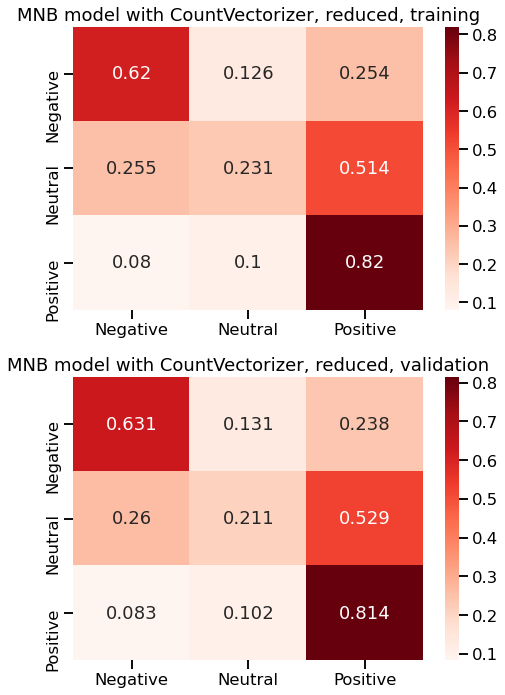

In [168]:
simple_model_validation(mnb3, datasets_list_count2_val,
                        'MNB model with CountVectorizer, reduced, training',
                        'MNB model with CountVectorizer, reduced, validation')


In [169]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'MNB model with CountVectorizer, reduced',
                                         'mnb3',
                                          datasets_list_count2_val,
                                          mnb3,
                                         'not saved, fast fitting')

In [170]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl
8,xgb1,XGBClassifier model with CountVectorizer,training,0.726,0.606,not saved; fast fitting
9,xgb1,XGBClassifier model with CountVectorizer,val/test,0.726,0.522,not saved; fast fitting


### LogisticRegressionCVClassifier

In [171]:
# params = {'solver' : ['newton-cg', 'lbfgs', 'sag','lblinear'],
#          'penalty': ['l1','l2']}


# gridsearch = GridSearchCV(LogisticRegressionCV(max_iter=1000, random_state=123,
#                                                class_weight='balanced',
#                                                multi_class='multinomial'), params, n_jobs=-1,
#                           cv=3, verbose=2, scoring = 'f1_macro')

# gridsearch.fit(vec_tfidf2_X_train,y_main_train)

In [172]:
# gridsearch.best_params_

In [173]:
# lrcv4=LogisticRegressionCV(max_iter=1000, random_state=123,
#                            class_weight='balanced',
#                            multi_class='multinomial',
#                            penalty='l2',
#                            solver='newton-cg',
#                            scoring='f1_macro')
# lrcv4.fit(vec_tfidf2_X_train,y_main_train)

In [174]:
# filename = 'models/LRCV_best_tfidf_red_fitted.pkl'
# pickle.dump(lrcv4, open(filename, 'wb'))

In [175]:
filename = 'models/LRCV_best_tfidf_red_fitted.pkl'
lrcv4_loaded_model = pickle.load(open(filename, 'rb'))

***************************************
LogisticRegressionCV(class_weight='balanced', max_iter=1000,
                     multi_class='multinomial', random_state=123,
                     scoring='f1_macro', solver='newton-cg')
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.52      0.68      0.59     13360
           2       0.34      0.41      0.37     15112
           3       0.81      0.67      0.73     39939

    accuracy                           0.61     68411
   macro avg       0.56      0.59      0.56     68411
weighted avg       0.65      0.61      0.63     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.52      0.68      0.59      4489
           2       0.33      0.39      0.35      5072
           3       0.

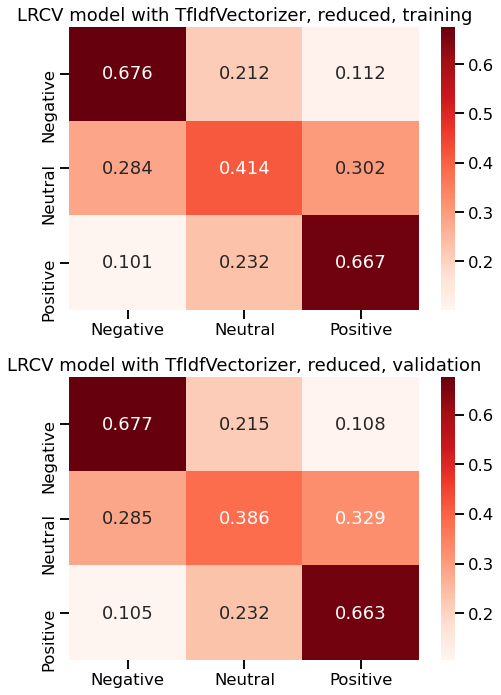

In [176]:
simple_model_validation(lrcv4_loaded_model, datasets_list_tfidf2_val,
                        'LRCV model with TfIdfVectorizer, reduced, training',
                        'LRCV model with TfIdfVectorizer, reduced, validation')


In [177]:
models_dict_params=adding_to_models_dict(models_dict,
                                         'LRCV model with TfIdfVectorizer, reduced, reduced',
                                         'lrcv4_loaded_model',
                                          datasets_list_tfidf2_val,
                                          lrcv4_loaded_model,
                                         'models/LRCV_best_tfidf_red_fitted.pkl')

In [178]:
models_df=pd.DataFrame(models_dict_params)
models_df

,Classifier Name,Description,Training or Val/Test,Accuracy,F1 Score,Saved model
0,dummy_num_model,Dummy with CountVectorizer,training,0.584,0.246,not saved
1,dummy_num_model,Dummy with CountVectorizer,val/test,0.584,0.245,not saved
2,mnb1,MultinomialNB model with CountVectorizer,training,0.726,0.645,not saved; fast fitting
3,mnb1,MultinomialNB model with CountVectorizer,val/test,0.726,0.570,not saved; fast fitting
4,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,training,0.764,0.684,models/LRCV_count_fitted.pkl
5,lrcv1_loaded_model,LogisticRegressionCV model with CountVectorizer,val/test,0.764,0.556,models/LRCV_count_fitted.pkl
6,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,training,0.773,0.699,models/LRCV_tfidf_fitted.pkl
7,lrcv2_loaded_model,LogisticRegressionCV model with TfIdfVectorizer,val/test,0.773,0.561,models/LRCV_tfidf_fitted.pkl
8,xgb1,XGBClassifier model with CountVectorizer,training,0.726,0.606,not saved; fast fitting
9,xgb1,XGBClassifier model with CountVectorizer,val/test,0.726,0.522,not saved; fast fitting


## Final testing

X_train, X_test, y_train, y_test

In [179]:
# token_reviews_test=[' '.join(review_tokenize_lemmatize(str(review), RegexpTokenizer(pattern), WordNetLemmatizer(),dict_replace, 
#                                                      sw2, plot_=False,print_=False)) for review in X_test]


In [180]:
# with open('token_reviews_test.pkl', 'wb') as f:
#     pickle.dump(token_reviews_test, f)

In [181]:
with open('token_reviews_test.pkl', 'rb') as f:
    token_reviews_test = pickle.load(f)

In [182]:
len(token_reviews_test)

30405

In [183]:
vec_count2_X_test=vec_count2.transform(token_reviews_test)
df_vec_count2_test=pd.DataFrame(vec_count2_X_test.todense(), columns=vec_count2.get_feature_names())
df_vec_count2_test

,able,actually,advance,advancement,allow,almost,along,alot,also,always,...,worklife,worklife balance,workplace,world,worth,would,would recommend,write,year,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,1
30401,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30402,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30403,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [184]:
vec_tfidf2_X_test=vec_tfidf2.transform(token_reviews_test)
df_vec_tfidf2_test=pd.DataFrame(vec_tfidf2_X_test.todense(), columns=vec_tfidf2.get_feature_names())
df_vec_tfidf2_test

,able,actually,advance,advancement,allow,almost,along,alot,also,always,...,worklife,worklife balance,workplace,world,worth,would,would recommend,write,year,youre
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30400,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.404432,0.0,0.0,0.00000,0.303212
30401,0.401454,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
30402,0.000000,0.0,0.0,0.395509,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
30403,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.37829,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000


In [185]:
datasets_list_count2_test=[vec_count2_X_train, vec_count2_X_test, y_main_train, y_test]
datasets_list_tfidf2_test=[vec_tfidf2_X_train, vec_tfidf2_X_test, y_main_train, y_test]

***************************************
MultinomialNB(alpha=0.3)
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.54      0.62      0.58     13360
           2       0.38      0.23      0.29     15112
           3       0.75      0.82      0.78     39939

    accuracy                           0.65     68411
   macro avg       0.56      0.56      0.55     68411
weighted avg       0.63      0.65      0.63     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.54      0.62      0.57      5899
           2       0.37      0.22      0.28      6666
           3       0.75      0.82      0.78     17840

    accuracy                           0.65     30405
   macro avg       0.55      0.55      0.54     30405
weighted avg       0.

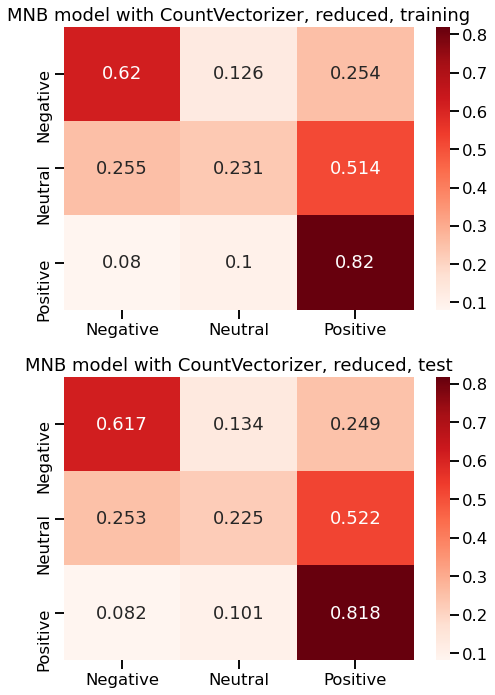

In [186]:
simple_model_validation(mnb3, datasets_list_count2_test,
                        'MNB model with CountVectorizer, reduced, training',
                        'MNB model with CountVectorizer, reduced, test')


***************************************
LogisticRegressionCV(class_weight='balanced', max_iter=1000,
                     multi_class='multinomial', random_state=123,
                     scoring='f1_macro', solver='newton-cg')
***************************************

Classification Report for training set
***************************************
              precision    recall  f1-score   support

           1       0.52      0.68      0.59     13360
           2       0.34      0.41      0.37     15112
           3       0.81      0.67      0.73     39939

    accuracy                           0.61     68411
   macro avg       0.56      0.59      0.56     68411
weighted avg       0.65      0.61      0.63     68411


Classification Report for validation/test set
***************************************
              precision    recall  f1-score   support

           1       0.52      0.68      0.59      5899
           2       0.33      0.41      0.36      6666
           3       0.

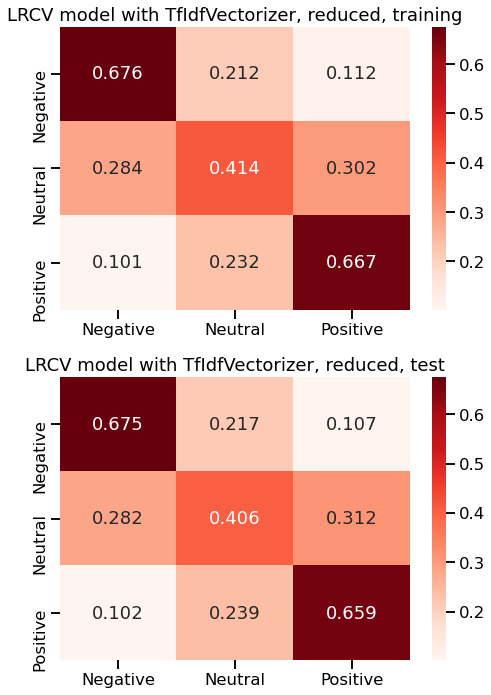

In [187]:
simple_model_validation(lrcv4_loaded_model, datasets_list_tfidf2_test,
                        'LRCV model with TfIdfVectorizer, reduced, training',
                        'LRCV model with TfIdfVectorizer, reduced, test')


# iNterpret

## Word frequency

## Feature Importance

# Conclusions and recommendations

## Conclusions

## Recommendations